In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_2.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
24136,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
24137,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
24138,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
24139,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
24140,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 24141/24141 [02:50<00:00, 141.33it/s]


In [4]:
# converting the list to numpy array
X = np.array(train_image,np.float16)
train_image=[]
# shape of the array
X.shape

(24141, 224, 224, 3)

In [5]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [6]:
X=[]
y=[]

In [7]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 224, 224, 3)
(4829, 224, 224, 3)
(19312, 51)
(4829, 51)


In [9]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [10]:
print(base_model.output_shape)

(None, None, None, 2048)


In [11]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv2_block3_out (Add)          (None, None, None, 2 0           max_pooling2d_1[0][0]            
                                                                 conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_preact_relu (Activ (None, None, None, 2 0           conv3_block1_preact_bn[0][0]     
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, None, None, 1 32768       conv3_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block3_2_relu (Activation (None, None, None, 2 0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_out (Add)          (None, None, None, 1 0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_preact_relu (Activ (None, None, None, 1 0           conv4_block4_preact_bn[0][0]     
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block10_out (Add)         (None, None, None, 1 0           conv4_block9_out[0][0]           
                                                                 conv4_block10_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_preact_bn (BatchN (None, None, None, 1 4096        conv4_block10_out[0][0]          
__________________________________________________________________________________________________
conv4_block11_preact_relu (Acti (None, None, None, 1 0           conv4_block11_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block11_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block11_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

__________________________________________________________________________________________________
conv4_block18_preact_bn (BatchN (None, None, None, 1 4096        conv4_block17_out[0][0]          
__________________________________________________________________________________________________
conv4_block18_preact_relu (Acti (None, None, None, 1 0           conv4_block18_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block18_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block18_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_block18_1_bn (BatchNormal (None, None, None, 2 1024        conv4_block18_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block18_1_relu (Activatio (None, None, None, 2 0           conv4_block18_1_bn[0][0]         
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

                                                                 conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_preact_bn (BatchNo (None, None, None, 2 8192        conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_preact_relu (Activ (None, None, None, 2 0           conv5_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, None, None, 5 1048576     conv5_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [12]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(19312, 7*7*2048)

# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train_2.pkl') 

t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

X_test = X_test.reshape(4829, 7*7*2048)

joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_2.pkl')

In [13]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train_2.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test_2.pkl') 

In [14]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 100352)
(4829, 100352)
(19312, 51)
(4829, 51)


In [15]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [16]:
model.output_shape

(None, 51)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [18]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_5.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [19]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adadelta',metrics=['accuracy'])

In [20]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-12-06 18:46:22.688161
Train on 19312 samples, validate on 4829 samples
Epoch 1/100
19312/19312 [==============================] - ETA: 21:40 - loss: 8.4011 - accuracy: 0.046 - ETA: 14:37 - loss: 32.6350 - accuracy: 0.09 - ETA: 11:24 - loss: 53.1415 - accuracy: 0.08 - ETA: 9:43 - loss: 54.9710 - accuracy: 0.0762 - ETA: 8:43 - loss: 55.2986 - accuracy: 0.065 - ETA: 7:58 - loss: 51.9287 - accuracy: 0.069 - ETA: 7:27 - loss: 47.3347 - accuracy: 0.071 - ETA: 7:06 - loss: 42.9827 - accuracy: 0.085 - ETA: 6:47 - loss: 39.0296 - accuracy: 0.093 - ETA: 6:33 - loss: 35.5929 - accuracy: 0.098 - ETA: 6:22 - loss: 32.7267 - accuracy: 0.112 - ETA: 6:09 - loss: 30.2857 - accuracy: 0.125 - ETA: 5:59 - loss: 28.2314 - accuracy: 0.128 - ETA: 5:50 - loss: 26.4721 - accuracy: 0.135 - ETA: 5:41 - loss: 24.9375 - accuracy: 0.146 - ETA: 5:34 - loss: 23.5980 - accuracy: 0.150 - ETA: 5:26 - loss: 22.4500 - accuracy: 0.149 - ETA: 5:19 - loss: 21.3977 - accuracy: 0.150 - ETA: 5:13 - loss: 20.4651 - accuracy

19312/19312 [==============================] - ETA: 3:27 - loss: 2.1504 - accuracy: 0.47 - ETA: 3:26 - loss: 2.2064 - accuracy: 0.48 - ETA: 3:22 - loss: 2.0987 - accuracy: 0.48 - ETA: 3:19 - loss: 2.0924 - accuracy: 0.49 - ETA: 3:20 - loss: 2.0277 - accuracy: 0.50 - ETA: 3:20 - loss: 1.9256 - accuracy: 0.52 - ETA: 3:25 - loss: 1.9215 - accuracy: 0.53 - ETA: 3:22 - loss: 1.9343 - accuracy: 0.52 - ETA: 3:20 - loss: 1.9259 - accuracy: 0.53 - ETA: 3:17 - loss: 1.8904 - accuracy: 0.54 - ETA: 3:15 - loss: 1.9223 - accuracy: 0.53 - ETA: 3:14 - loss: 1.9130 - accuracy: 0.53 - ETA: 3:11 - loss: 1.9417 - accuracy: 0.53 - ETA: 3:09 - loss: 1.9484 - accuracy: 0.53 - ETA: 3:08 - loss: 1.9637 - accuracy: 0.53 - ETA: 3:06 - loss: 1.9582 - accuracy: 0.53 - ETA: 3:04 - loss: 1.9662 - accuracy: 0.53 - ETA: 3:04 - loss: 1.9963 - accuracy: 0.53 - ETA: 3:02 - loss: 2.0019 - accuracy: 0.53 - ETA: 3:01 - loss: 1.9948 - accuracy: 0.53 - ETA: 2:59 - loss: 1.9853 - accuracy: 0.53 - ETA: 2:58 - loss: 1.9855 - ac

19312/19312 [==============================] - ETA: 3:31 - loss: 1.2772 - accuracy: 0.66 - ETA: 3:27 - loss: 1.2235 - accuracy: 0.67 - ETA: 3:22 - loss: 1.3735 - accuracy: 0.64 - ETA: 3:19 - loss: 1.4076 - accuracy: 0.62 - ETA: 3:17 - loss: 1.4160 - accuracy: 0.62 - ETA: 3:16 - loss: 1.3891 - accuracy: 0.63 - ETA: 3:14 - loss: 1.4149 - accuracy: 0.62 - ETA: 3:14 - loss: 1.4367 - accuracy: 0.62 - ETA: 3:14 - loss: 1.4140 - accuracy: 0.62 - ETA: 3:13 - loss: 1.4068 - accuracy: 0.62 - ETA: 3:11 - loss: 1.4308 - accuracy: 0.62 - ETA: 3:10 - loss: 1.4482 - accuracy: 0.62 - ETA: 3:08 - loss: 1.4690 - accuracy: 0.62 - ETA: 3:07 - loss: 1.4816 - accuracy: 0.61 - ETA: 3:05 - loss: 1.4956 - accuracy: 0.61 - ETA: 3:04 - loss: 1.5110 - accuracy: 0.61 - ETA: 3:03 - loss: 1.5178 - accuracy: 0.61 - ETA: 3:01 - loss: 1.5178 - accuracy: 0.61 - ETA: 3:00 - loss: 1.4988 - accuracy: 0.61 - ETA: 2:59 - loss: 1.4978 - accuracy: 0.61 - ETA: 2:58 - loss: 1.4850 - accuracy: 0.62 - ETA: 2:56 - loss: 1.4911 - ac

19312/19312 [==============================] - ETA: 3:47 - loss: 1.1067 - accuracy: 0.70 - ETA: 3:32 - loss: 1.0532 - accuracy: 0.69 - ETA: 3:26 - loss: 1.1921 - accuracy: 0.68 - ETA: 3:21 - loss: 1.2072 - accuracy: 0.68 - ETA: 3:19 - loss: 1.1404 - accuracy: 0.69 - ETA: 3:16 - loss: 1.1374 - accuracy: 0.69 - ETA: 3:15 - loss: 1.1624 - accuracy: 0.68 - ETA: 3:13 - loss: 1.1809 - accuracy: 0.68 - ETA: 3:11 - loss: 1.1757 - accuracy: 0.68 - ETA: 3:09 - loss: 1.1881 - accuracy: 0.68 - ETA: 3:08 - loss: 1.1787 - accuracy: 0.68 - ETA: 3:07 - loss: 1.1681 - accuracy: 0.69 - ETA: 3:05 - loss: 1.1390 - accuracy: 0.69 - ETA: 3:04 - loss: 1.1499 - accuracy: 0.69 - ETA: 3:02 - loss: 1.1428 - accuracy: 0.69 - ETA: 3:01 - loss: 1.1358 - accuracy: 0.69 - ETA: 3:00 - loss: 1.1298 - accuracy: 0.69 - ETA: 2:59 - loss: 1.1357 - accuracy: 0.70 - ETA: 2:58 - loss: 1.1407 - accuracy: 0.70 - ETA: 2:57 - loss: 1.1547 - accuracy: 0.70 - ETA: 2:55 - loss: 1.1451 - accuracy: 0.70 - ETA: 2:54 - loss: 1.1460 - ac

19312/19312 [==============================] - ETA: 3:26 - loss: 1.0398 - accuracy: 0.73 - ETA: 3:22 - loss: 1.1230 - accuracy: 0.71 - ETA: 3:20 - loss: 0.9921 - accuracy: 0.74 - ETA: 3:18 - loss: 0.9178 - accuracy: 0.75 - ETA: 3:14 - loss: 0.8991 - accuracy: 0.75 - ETA: 3:13 - loss: 0.9551 - accuracy: 0.73 - ETA: 3:10 - loss: 0.9439 - accuracy: 0.73 - ETA: 3:09 - loss: 0.9746 - accuracy: 0.73 - ETA: 3:09 - loss: 1.0035 - accuracy: 0.72 - ETA: 3:08 - loss: 0.9810 - accuracy: 0.73 - ETA: 3:07 - loss: 0.9621 - accuracy: 0.73 - ETA: 3:06 - loss: 0.9499 - accuracy: 0.74 - ETA: 3:05 - loss: 0.9425 - accuracy: 0.74 - ETA: 3:04 - loss: 0.9253 - accuracy: 0.74 - ETA: 3:02 - loss: 0.9190 - accuracy: 0.74 - ETA: 3:00 - loss: 0.9193 - accuracy: 0.75 - ETA: 2:59 - loss: 0.9268 - accuracy: 0.74 - ETA: 2:58 - loss: 0.9430 - accuracy: 0.74 - ETA: 2:56 - loss: 0.9423 - accuracy: 0.74 - ETA: 2:55 - loss: 0.9476 - accuracy: 0.74 - ETA: 2:54 - loss: 0.9426 - accuracy: 0.74 - ETA: 2:53 - loss: 0.9316 - ac

19312/19312 [==============================] - ETA: 3:28 - loss: 0.7654 - accuracy: 0.76 - ETA: 3:19 - loss: 0.8155 - accuracy: 0.74 - ETA: 3:15 - loss: 0.8440 - accuracy: 0.75 - ETA: 3:13 - loss: 0.8359 - accuracy: 0.75 - ETA: 3:12 - loss: 0.8656 - accuracy: 0.75 - ETA: 3:11 - loss: 0.8494 - accuracy: 0.75 - ETA: 3:11 - loss: 0.8605 - accuracy: 0.75 - ETA: 3:11 - loss: 0.8607 - accuracy: 0.76 - ETA: 3:11 - loss: 0.8521 - accuracy: 0.76 - ETA: 3:10 - loss: 0.8280 - accuracy: 0.77 - ETA: 3:10 - loss: 0.8211 - accuracy: 0.77 - ETA: 3:07 - loss: 0.8429 - accuracy: 0.76 - ETA: 3:06 - loss: 0.8297 - accuracy: 0.77 - ETA: 3:05 - loss: 0.8322 - accuracy: 0.77 - ETA: 3:04 - loss: 0.8359 - accuracy: 0.77 - ETA: 3:02 - loss: 0.8279 - accuracy: 0.77 - ETA: 3:01 - loss: 0.8256 - accuracy: 0.77 - ETA: 3:00 - loss: 0.8122 - accuracy: 0.77 - ETA: 2:58 - loss: 0.8256 - accuracy: 0.77 - ETA: 2:58 - loss: 0.8233 - accuracy: 0.77 - ETA: 2:57 - loss: 0.8125 - accuracy: 0.77 - ETA: 2:55 - loss: 0.8123 - ac

19312/19312 [==============================] - ETA: 3:20 - loss: 0.6342 - accuracy: 0.82 - ETA: 3:28 - loss: 0.5692 - accuracy: 0.83 - ETA: 3:26 - loss: 0.7259 - accuracy: 0.80 - ETA: 3:25 - loss: 0.7035 - accuracy: 0.81 - ETA: 3:21 - loss: 0.7012 - accuracy: 0.80 - ETA: 3:19 - loss: 0.7122 - accuracy: 0.79 - ETA: 3:17 - loss: 0.6895 - accuracy: 0.80 - ETA: 3:15 - loss: 0.6666 - accuracy: 0.81 - ETA: 3:14 - loss: 0.6770 - accuracy: 0.81 - ETA: 3:12 - loss: 0.6790 - accuracy: 0.81 - ETA: 3:10 - loss: 0.6585 - accuracy: 0.81 - ETA: 3:08 - loss: 0.6630 - accuracy: 0.81 - ETA: 3:08 - loss: 0.6571 - accuracy: 0.81 - ETA: 3:06 - loss: 0.6650 - accuracy: 0.81 - ETA: 3:05 - loss: 0.6484 - accuracy: 0.81 - ETA: 3:04 - loss: 0.6495 - accuracy: 0.81 - ETA: 3:03 - loss: 0.6382 - accuracy: 0.81 - ETA: 3:01 - loss: 0.6402 - accuracy: 0.81 - ETA: 3:00 - loss: 0.6408 - accuracy: 0.81 - ETA: 2:58 - loss: 0.6343 - accuracy: 0.81 - ETA: 2:58 - loss: 0.6330 - accuracy: 0.82 - ETA: 2:56 - loss: 0.6205 - ac

19312/19312 [==============================] - ETA: 5:31 - loss: 0.7127 - accuracy: 0.82 - ETA: 5:18 - loss: 0.6382 - accuracy: 0.83 - ETA: 5:20 - loss: 0.6771 - accuracy: 0.82 - ETA: 5:14 - loss: 0.6251 - accuracy: 0.82 - ETA: 5:12 - loss: 0.5872 - accuracy: 0.84 - ETA: 5:10 - loss: 0.5952 - accuracy: 0.83 - ETA: 5:07 - loss: 0.6019 - accuracy: 0.83 - ETA: 5:02 - loss: 0.5994 - accuracy: 0.83 - ETA: 5:00 - loss: 0.5956 - accuracy: 0.83 - ETA: 4:58 - loss: 0.5793 - accuracy: 0.84 - ETA: 4:56 - loss: 0.5739 - accuracy: 0.84 - ETA: 4:54 - loss: 0.5885 - accuracy: 0.84 - ETA: 4:53 - loss: 0.5853 - accuracy: 0.84 - ETA: 4:50 - loss: 0.6035 - accuracy: 0.83 - ETA: 4:48 - loss: 0.6020 - accuracy: 0.84 - ETA: 4:46 - loss: 0.6158 - accuracy: 0.83 - ETA: 4:44 - loss: 0.6005 - accuracy: 0.83 - ETA: 4:42 - loss: 0.5967 - accuracy: 0.83 - ETA: 4:41 - loss: 0.5977 - accuracy: 0.84 - ETA: 4:39 - loss: 0.5879 - accuracy: 0.84 - ETA: 4:36 - loss: 0.5858 - accuracy: 0.84 - ETA: 4:34 - loss: 0.5795 - ac

19312/19312 [==============================] - ETA: 5:21 - loss: 0.6103 - accuracy: 0.82 - ETA: 5:14 - loss: 0.7409 - accuracy: 0.81 - ETA: 5:14 - loss: 0.6956 - accuracy: 0.82 - ETA: 5:11 - loss: 0.6265 - accuracy: 0.83 - ETA: 5:08 - loss: 0.6268 - accuracy: 0.83 - ETA: 5:07 - loss: 0.5738 - accuracy: 0.83 - ETA: 5:04 - loss: 0.5608 - accuracy: 0.84 - ETA: 5:03 - loss: 0.5635 - accuracy: 0.83 - ETA: 5:01 - loss: 0.5513 - accuracy: 0.84 - ETA: 4:58 - loss: 0.5359 - accuracy: 0.84 - ETA: 4:57 - loss: 0.5278 - accuracy: 0.85 - ETA: 4:55 - loss: 0.5283 - accuracy: 0.85 - ETA: 4:54 - loss: 0.5369 - accuracy: 0.84 - ETA: 4:52 - loss: 0.5244 - accuracy: 0.84 - ETA: 4:50 - loss: 0.5245 - accuracy: 0.84 - ETA: 4:47 - loss: 0.5183 - accuracy: 0.85 - ETA: 4:45 - loss: 0.5288 - accuracy: 0.84 - ETA: 4:42 - loss: 0.5328 - accuracy: 0.85 - ETA: 4:39 - loss: 0.5292 - accuracy: 0.85 - ETA: 4:37 - loss: 0.5302 - accuracy: 0.84 - ETA: 4:36 - loss: 0.5362 - accuracy: 0.84 - ETA: 4:34 - loss: 0.5344 - ac

19312/19312 [==============================] - ETA: 5:21 - loss: 0.6305 - accuracy: 0.84 - ETA: 5:23 - loss: 0.4865 - accuracy: 0.88 - ETA: 5:23 - loss: 0.4858 - accuracy: 0.86 - ETA: 5:20 - loss: 0.4692 - accuracy: 0.87 - ETA: 5:16 - loss: 0.4698 - accuracy: 0.87 - ETA: 5:13 - loss: 0.5157 - accuracy: 0.86 - ETA: 5:11 - loss: 0.4954 - accuracy: 0.87 - ETA: 5:09 - loss: 0.4760 - accuracy: 0.87 - ETA: 5:06 - loss: 0.4541 - accuracy: 0.87 - ETA: 5:03 - loss: 0.4474 - accuracy: 0.87 - ETA: 5:00 - loss: 0.4333 - accuracy: 0.88 - ETA: 4:58 - loss: 0.4301 - accuracy: 0.88 - ETA: 4:56 - loss: 0.4259 - accuracy: 0.88 - ETA: 4:54 - loss: 0.4436 - accuracy: 0.87 - ETA: 4:52 - loss: 0.4403 - accuracy: 0.87 - ETA: 4:52 - loss: 0.4400 - accuracy: 0.87 - ETA: 4:50 - loss: 0.4470 - accuracy: 0.87 - ETA: 4:47 - loss: 0.4384 - accuracy: 0.87 - ETA: 4:45 - loss: 0.4385 - accuracy: 0.87 - ETA: 4:42 - loss: 0.4476 - accuracy: 0.87 - ETA: 4:40 - loss: 0.4459 - accuracy: 0.87 - ETA: 4:37 - loss: 0.4470 - ac

19312/19312 [==============================] - ETA: 5:10 - loss: 0.4661 - accuracy: 0.89 - ETA: 5:20 - loss: 0.5132 - accuracy: 0.85 - ETA: 5:17 - loss: 0.4443 - accuracy: 0.87 - ETA: 5:13 - loss: 0.4515 - accuracy: 0.87 - ETA: 5:11 - loss: 0.4348 - accuracy: 0.87 - ETA: 5:08 - loss: 0.4549 - accuracy: 0.87 - ETA: 5:06 - loss: 0.4657 - accuracy: 0.87 - ETA: 5:06 - loss: 0.4520 - accuracy: 0.88 - ETA: 5:04 - loss: 0.4596 - accuracy: 0.88 - ETA: 5:02 - loss: 0.4414 - accuracy: 0.88 - ETA: 5:01 - loss: 0.4332 - accuracy: 0.88 - ETA: 5:01 - loss: 0.4477 - accuracy: 0.88 - ETA: 4:59 - loss: 0.4426 - accuracy: 0.88 - ETA: 4:58 - loss: 0.4449 - accuracy: 0.88 - ETA: 4:57 - loss: 0.4394 - accuracy: 0.88 - ETA: 4:57 - loss: 0.4308 - accuracy: 0.88 - ETA: 4:56 - loss: 0.4308 - accuracy: 0.88 - ETA: 4:55 - loss: 0.4250 - accuracy: 0.88 - ETA: 4:54 - loss: 0.4199 - accuracy: 0.88 - ETA: 4:51 - loss: 0.4238 - accuracy: 0.88 - ETA: 4:48 - loss: 0.4248 - accuracy: 0.88 - ETA: 4:45 - loss: 0.4231 - ac

19312/19312 [==============================] - ETA: 5:24 - loss: 0.1927 - accuracy: 0.93 - ETA: 5:09 - loss: 0.3018 - accuracy: 0.92 - ETA: 5:05 - loss: 0.2623 - accuracy: 0.92 - ETA: 5:00 - loss: 0.3035 - accuracy: 0.91 - ETA: 4:58 - loss: 0.2797 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2917 - accuracy: 0.91 - ETA: 4:57 - loss: 0.2785 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2946 - accuracy: 0.91 - ETA: 4:54 - loss: 0.3190 - accuracy: 0.90 - ETA: 4:53 - loss: 0.3107 - accuracy: 0.90 - ETA: 4:52 - loss: 0.3226 - accuracy: 0.90 - ETA: 4:51 - loss: 0.3448 - accuracy: 0.90 - ETA: 4:49 - loss: 0.3450 - accuracy: 0.90 - ETA: 4:47 - loss: 0.3416 - accuracy: 0.90 - ETA: 4:45 - loss: 0.3559 - accuracy: 0.90 - ETA: 4:43 - loss: 0.3649 - accuracy: 0.89 - ETA: 4:42 - loss: 0.3718 - accuracy: 0.89 - ETA: 4:40 - loss: 0.3708 - accuracy: 0.89 - ETA: 4:38 - loss: 0.3713 - accuracy: 0.89 - ETA: 4:36 - loss: 0.3724 - accuracy: 0.89 - ETA: 4:34 - loss: 0.3742 - accuracy: 0.89 - ETA: 4:32 - loss: 0.3726 - ac

19312/19312 [==============================] - ETA: 5:48 - loss: 0.2454 - accuracy: 0.91 - ETA: 5:32 - loss: 0.2478 - accuracy: 0.92 - ETA: 5:27 - loss: 0.2524 - accuracy: 0.92 - ETA: 5:27 - loss: 0.2528 - accuracy: 0.91 - ETA: 5:24 - loss: 0.2497 - accuracy: 0.92 - ETA: 5:21 - loss: 0.2523 - accuracy: 0.92 - ETA: 5:17 - loss: 0.2555 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2569 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2714 - accuracy: 0.91 - ETA: 5:06 - loss: 0.2711 - accuracy: 0.91 - ETA: 5:04 - loss: 0.2715 - accuracy: 0.91 - ETA: 5:01 - loss: 0.2940 - accuracy: 0.91 - ETA: 4:58 - loss: 0.2933 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2904 - accuracy: 0.91 - ETA: 4:54 - loss: 0.3001 - accuracy: 0.91 - ETA: 4:51 - loss: 0.2971 - accuracy: 0.91 - ETA: 4:50 - loss: 0.3000 - accuracy: 0.91 - ETA: 4:48 - loss: 0.3132 - accuracy: 0.90 - ETA: 4:45 - loss: 0.3152 - accuracy: 0.90 - ETA: 4:43 - loss: 0.3345 - accuracy: 0.90 - ETA: 4:40 - loss: 0.3411 - accuracy: 0.90 - ETA: 4:37 - loss: 0.3456 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 0.4206 - accuracy: 0.88 - ETA: 5:13 - loss: 0.4735 - accuracy: 0.87 - ETA: 5:11 - loss: 0.4397 - accuracy: 0.88 - ETA: 5:07 - loss: 0.4252 - accuracy: 0.89 - ETA: 5:02 - loss: 0.3720 - accuracy: 0.90 - ETA: 5:01 - loss: 0.3423 - accuracy: 0.91 - ETA: 5:01 - loss: 0.3675 - accuracy: 0.91 - ETA: 4:58 - loss: 0.3532 - accuracy: 0.91 - ETA: 4:59 - loss: 0.3393 - accuracy: 0.91 - ETA: 4:57 - loss: 0.3473 - accuracy: 0.91 - ETA: 4:55 - loss: 0.3647 - accuracy: 0.90 - ETA: 4:54 - loss: 0.3476 - accuracy: 0.90 - ETA: 4:52 - loss: 0.3611 - accuracy: 0.90 - ETA: 4:50 - loss: 0.3572 - accuracy: 0.90 - ETA: 4:47 - loss: 0.3484 - accuracy: 0.90 - ETA: 4:45 - loss: 0.3457 - accuracy: 0.90 - ETA: 4:43 - loss: 0.3420 - accuracy: 0.90 - ETA: 4:42 - loss: 0.3421 - accuracy: 0.90 - ETA: 4:39 - loss: 0.3402 - accuracy: 0.91 - ETA: 4:37 - loss: 0.3345 - accuracy: 0.91 - ETA: 4:36 - loss: 0.3339 - accuracy: 0.91 - ETA: 4:33 - loss: 0.3301 - ac

19312/19312 [==============================] - ETA: 5:24 - loss: 0.2563 - accuracy: 0.93 - ETA: 5:22 - loss: 0.1978 - accuracy: 0.94 - ETA: 5:21 - loss: 0.1628 - accuracy: 0.94 - ETA: 5:15 - loss: 0.2468 - accuracy: 0.93 - ETA: 5:16 - loss: 0.2498 - accuracy: 0.92 - ETA: 5:14 - loss: 0.2583 - accuracy: 0.92 - ETA: 5:11 - loss: 0.2606 - accuracy: 0.92 - ETA: 5:08 - loss: 0.2575 - accuracy: 0.92 - ETA: 5:06 - loss: 0.2657 - accuracy: 0.92 - ETA: 5:02 - loss: 0.2704 - accuracy: 0.92 - ETA: 5:01 - loss: 0.2693 - accuracy: 0.92 - ETA: 4:59 - loss: 0.2674 - accuracy: 0.92 - ETA: 4:55 - loss: 0.2687 - accuracy: 0.92 - ETA: 4:54 - loss: 0.2663 - accuracy: 0.92 - ETA: 4:52 - loss: 0.2763 - accuracy: 0.92 - ETA: 4:50 - loss: 0.2776 - accuracy: 0.92 - ETA: 4:48 - loss: 0.2834 - accuracy: 0.92 - ETA: 4:45 - loss: 0.2864 - accuracy: 0.92 - ETA: 4:43 - loss: 0.2833 - accuracy: 0.92 - ETA: 4:41 - loss: 0.2956 - accuracy: 0.92 - ETA: 4:39 - loss: 0.2958 - accuracy: 0.92 - ETA: 4:37 - loss: 0.2915 - ac

19312/19312 [==============================] - ETA: 5:15 - loss: 0.2681 - accuracy: 0.96 - ETA: 5:23 - loss: 0.2874 - accuracy: 0.92 - ETA: 5:16 - loss: 0.3160 - accuracy: 0.92 - ETA: 5:15 - loss: 0.3069 - accuracy: 0.92 - ETA: 5:12 - loss: 0.2944 - accuracy: 0.92 - ETA: 5:09 - loss: 0.3037 - accuracy: 0.92 - ETA: 5:08 - loss: 0.3179 - accuracy: 0.92 - ETA: 5:08 - loss: 0.3028 - accuracy: 0.92 - ETA: 5:07 - loss: 0.3049 - accuracy: 0.92 - ETA: 5:05 - loss: 0.2948 - accuracy: 0.92 - ETA: 5:03 - loss: 0.3005 - accuracy: 0.92 - ETA: 5:00 - loss: 0.2967 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2945 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2879 - accuracy: 0.92 - ETA: 4:54 - loss: 0.2833 - accuracy: 0.92 - ETA: 4:51 - loss: 0.2755 - accuracy: 0.92 - ETA: 4:47 - loss: 0.2710 - accuracy: 0.92 - ETA: 4:46 - loss: 0.2699 - accuracy: 0.92 - ETA: 4:43 - loss: 0.2758 - accuracy: 0.92 - ETA: 4:41 - loss: 0.2783 - accuracy: 0.92 - ETA: 4:39 - loss: 0.2810 - accuracy: 0.92 - ETA: 4:37 - loss: 0.2773 - ac

19312/19312 [==============================] - ETA: 3:35 - loss: 0.1550 - accuracy: 0.92 - ETA: 3:24 - loss: 0.3333 - accuracy: 0.91 - ETA: 3:19 - loss: 0.2905 - accuracy: 0.91 - ETA: 3:17 - loss: 0.3392 - accuracy: 0.90 - ETA: 3:15 - loss: 0.3533 - accuracy: 0.90 - ETA: 3:14 - loss: 0.3408 - accuracy: 0.90 - ETA: 3:12 - loss: 0.3132 - accuracy: 0.91 - ETA: 3:10 - loss: 0.2911 - accuracy: 0.92 - ETA: 3:08 - loss: 0.2863 - accuracy: 0.92 - ETA: 3:06 - loss: 0.2911 - accuracy: 0.92 - ETA: 3:05 - loss: 0.2955 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2881 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2951 - accuracy: 0.91 - ETA: 3:04 - loss: 0.2889 - accuracy: 0.92 - ETA: 3:02 - loss: 0.2834 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2866 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2875 - accuracy: 0.92 - ETA: 2:58 - loss: 0.2819 - accuracy: 0.92 - ETA: 2:56 - loss: 0.2766 - accuracy: 0.92 - ETA: 2:54 - loss: 0.2724 - accuracy: 0.92 - ETA: 2:54 - loss: 0.2703 - accuracy: 0.92 - ETA: 2:52 - loss: 0.2660 - ac

19312/19312 [==============================] - ETA: 3:15 - loss: 0.3808 - accuracy: 0.89 - ETA: 3:15 - loss: 0.3524 - accuracy: 0.91 - ETA: 3:14 - loss: 0.3121 - accuracy: 0.91 - ETA: 3:17 - loss: 0.3042 - accuracy: 0.92 - ETA: 3:18 - loss: 0.2752 - accuracy: 0.92 - ETA: 3:18 - loss: 0.2548 - accuracy: 0.93 - ETA: 3:16 - loss: 0.2596 - accuracy: 0.93 - ETA: 3:13 - loss: 0.2401 - accuracy: 0.93 - ETA: 3:12 - loss: 0.2527 - accuracy: 0.93 - ETA: 3:10 - loss: 0.2481 - accuracy: 0.93 - ETA: 3:09 - loss: 0.2429 - accuracy: 0.93 - ETA: 3:08 - loss: 0.2312 - accuracy: 0.93 - ETA: 3:07 - loss: 0.2326 - accuracy: 0.93 - ETA: 3:06 - loss: 0.2247 - accuracy: 0.93 - ETA: 3:05 - loss: 0.2163 - accuracy: 0.93 - ETA: 3:03 - loss: 0.2077 - accuracy: 0.93 - ETA: 3:02 - loss: 0.2094 - accuracy: 0.93 - ETA: 3:01 - loss: 0.2121 - accuracy: 0.93 - ETA: 3:00 - loss: 0.2144 - accuracy: 0.93 - ETA: 2:58 - loss: 0.2146 - accuracy: 0.93 - ETA: 2:57 - loss: 0.2205 - accuracy: 0.93 - ETA: 2:55 - loss: 0.2334 - ac

19312/19312 [==============================] - ETA: 3:35 - loss: 0.1901 - accuracy: 0.96 - ETA: 3:26 - loss: 0.2420 - accuracy: 0.94 - ETA: 3:21 - loss: 0.2215 - accuracy: 0.94 - ETA: 3:21 - loss: 0.2544 - accuracy: 0.93 - ETA: 3:19 - loss: 0.2158 - accuracy: 0.94 - ETA: 3:17 - loss: 0.2325 - accuracy: 0.94 - ETA: 3:16 - loss: 0.2355 - accuracy: 0.93 - ETA: 3:15 - loss: 0.2399 - accuracy: 0.93 - ETA: 3:14 - loss: 0.2516 - accuracy: 0.93 - ETA: 3:13 - loss: 0.2403 - accuracy: 0.93 - ETA: 3:12 - loss: 0.2336 - accuracy: 0.94 - ETA: 3:11 - loss: 0.2213 - accuracy: 0.94 - ETA: 3:09 - loss: 0.2156 - accuracy: 0.94 - ETA: 3:07 - loss: 0.2087 - accuracy: 0.94 - ETA: 3:06 - loss: 0.2153 - accuracy: 0.94 - ETA: 3:04 - loss: 0.2181 - accuracy: 0.94 - ETA: 3:03 - loss: 0.2206 - accuracy: 0.94 - ETA: 3:01 - loss: 0.2202 - accuracy: 0.94 - ETA: 3:00 - loss: 0.2110 - accuracy: 0.94 - ETA: 2:58 - loss: 0.2117 - accuracy: 0.94 - ETA: 2:57 - loss: 0.2148 - accuracy: 0.94 - ETA: 2:56 - loss: 0.2173 - ac

19312/19312 [==============================] - ETA: 3:29 - loss: 0.2220 - accuracy: 0.93 - ETA: 3:29 - loss: 0.2524 - accuracy: 0.92 - ETA: 3:30 - loss: 0.2338 - accuracy: 0.93 - ETA: 3:26 - loss: 0.2519 - accuracy: 0.92 - ETA: 3:21 - loss: 0.2184 - accuracy: 0.93 - ETA: 3:20 - loss: 0.1980 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1895 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1826 - accuracy: 0.94 - ETA: 3:15 - loss: 0.1858 - accuracy: 0.94 - ETA: 3:13 - loss: 0.1817 - accuracy: 0.94 - ETA: 3:12 - loss: 0.1831 - accuracy: 0.94 - ETA: 3:09 - loss: 0.1793 - accuracy: 0.94 - ETA: 3:08 - loss: 0.1787 - accuracy: 0.94 - ETA: 3:08 - loss: 0.1877 - accuracy: 0.94 - ETA: 3:07 - loss: 0.1844 - accuracy: 0.94 - ETA: 3:05 - loss: 0.1818 - accuracy: 0.94 - ETA: 3:03 - loss: 0.1915 - accuracy: 0.94 - ETA: 3:02 - loss: 0.1922 - accuracy: 0.94 - ETA: 3:00 - loss: 0.1925 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1865 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1938 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1959 - ac

19312/19312 [==============================] - ETA: 3:24 - loss: 0.1408 - accuracy: 0.96 - ETA: 3:20 - loss: 0.1707 - accuracy: 0.95 - ETA: 3:20 - loss: 0.1535 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1915 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1696 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1518 - accuracy: 0.95 - ETA: 3:15 - loss: 0.1436 - accuracy: 0.95 - ETA: 3:14 - loss: 0.1492 - accuracy: 0.95 - ETA: 3:13 - loss: 0.1435 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1625 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1700 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1690 - accuracy: 0.95 - ETA: 3:07 - loss: 0.1758 - accuracy: 0.94 - ETA: 3:06 - loss: 0.1757 - accuracy: 0.94 - ETA: 3:05 - loss: 0.1744 - accuracy: 0.94 - ETA: 3:03 - loss: 0.1753 - accuracy: 0.94 - ETA: 3:01 - loss: 0.1723 - accuracy: 0.94 - ETA: 3:00 - loss: 0.1689 - accuracy: 0.94 - ETA: 3:00 - loss: 0.1750 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1746 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1780 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1785 - ac

19312/19312 [==============================] - ETA: 3:28 - loss: 0.3928 - accuracy: 0.92 - ETA: 3:22 - loss: 0.4049 - accuracy: 0.91 - ETA: 3:22 - loss: 0.3106 - accuracy: 0.93 - ETA: 3:19 - loss: 0.2676 - accuracy: 0.93 - ETA: 3:16 - loss: 0.2535 - accuracy: 0.94 - ETA: 3:16 - loss: 0.2583 - accuracy: 0.94 - ETA: 3:15 - loss: 0.2467 - accuracy: 0.94 - ETA: 3:13 - loss: 0.2429 - accuracy: 0.94 - ETA: 3:12 - loss: 0.2241 - accuracy: 0.94 - ETA: 3:11 - loss: 0.2085 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1985 - accuracy: 0.95 - ETA: 3:10 - loss: 0.2022 - accuracy: 0.94 - ETA: 3:08 - loss: 0.2001 - accuracy: 0.94 - ETA: 3:07 - loss: 0.2066 - accuracy: 0.94 - ETA: 3:06 - loss: 0.2078 - accuracy: 0.94 - ETA: 3:04 - loss: 0.2184 - accuracy: 0.94 - ETA: 3:03 - loss: 0.2242 - accuracy: 0.94 - ETA: 3:01 - loss: 0.2206 - accuracy: 0.94 - ETA: 3:00 - loss: 0.2149 - accuracy: 0.94 - ETA: 2:58 - loss: 0.2156 - accuracy: 0.94 - ETA: 2:57 - loss: 0.2136 - accuracy: 0.94 - ETA: 2:56 - loss: 0.2160 - ac

19312/19312 [==============================] - ETA: 3:25 - loss: 0.3726 - accuracy: 0.92 - ETA: 3:21 - loss: 0.3132 - accuracy: 0.92 - ETA: 3:23 - loss: 0.3185 - accuracy: 0.92 - ETA: 3:23 - loss: 0.2840 - accuracy: 0.93 - ETA: 3:19 - loss: 0.2637 - accuracy: 0.93 - ETA: 3:17 - loss: 0.2476 - accuracy: 0.93 - ETA: 3:16 - loss: 0.2727 - accuracy: 0.94 - ETA: 3:14 - loss: 0.2572 - accuracy: 0.94 - ETA: 3:14 - loss: 0.2409 - accuracy: 0.94 - ETA: 3:13 - loss: 0.2352 - accuracy: 0.94 - ETA: 3:11 - loss: 0.2325 - accuracy: 0.94 - ETA: 3:09 - loss: 0.2249 - accuracy: 0.94 - ETA: 3:08 - loss: 0.2242 - accuracy: 0.94 - ETA: 3:07 - loss: 0.2257 - accuracy: 0.94 - ETA: 3:06 - loss: 0.2187 - accuracy: 0.94 - ETA: 3:05 - loss: 0.2077 - accuracy: 0.94 - ETA: 3:03 - loss: 0.2043 - accuracy: 0.94 - ETA: 3:02 - loss: 0.2041 - accuracy: 0.94 - ETA: 3:00 - loss: 0.2013 - accuracy: 0.94 - ETA: 2:58 - loss: 0.2020 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1988 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1949 - ac

19312/19312 [==============================] - ETA: 3:19 - loss: 0.0375 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0508 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0878 - accuracy: 0.98 - ETA: 3:20 - loss: 0.1125 - accuracy: 0.97 - ETA: 3:18 - loss: 0.1116 - accuracy: 0.97 - ETA: 3:18 - loss: 0.1063 - accuracy: 0.97 - ETA: 3:18 - loss: 0.1105 - accuracy: 0.96 - ETA: 3:17 - loss: 0.1313 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1422 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1385 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1412 - accuracy: 0.96 - ETA: 3:10 - loss: 0.1470 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1400 - accuracy: 0.96 - ETA: 3:06 - loss: 0.1354 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1407 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1500 - accuracy: 0.95 - ETA: 3:02 - loss: 0.1470 - accuracy: 0.95 - ETA: 3:02 - loss: 0.1448 - accuracy: 0.96 - ETA: 3:01 - loss: 0.1410 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1410 - accuracy: 0.96 - ETA: 2:58 - loss: 0.1438 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1485 - ac

19312/19312 [==============================] - ETA: 3:23 - loss: 0.1248 - accuracy: 0.96 - ETA: 3:17 - loss: 0.1325 - accuracy: 0.95 - ETA: 3:15 - loss: 0.1323 - accuracy: 0.95 - ETA: 3:14 - loss: 0.1189 - accuracy: 0.96 - ETA: 3:13 - loss: 0.1403 - accuracy: 0.95 - ETA: 3:14 - loss: 0.1488 - accuracy: 0.95 - ETA: 3:14 - loss: 0.1365 - accuracy: 0.96 - ETA: 3:13 - loss: 0.1486 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1562 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1693 - accuracy: 0.95 - ETA: 3:11 - loss: 0.1878 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1924 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1868 - accuracy: 0.95 - ETA: 3:07 - loss: 0.1856 - accuracy: 0.95 - ETA: 3:06 - loss: 0.1849 - accuracy: 0.95 - ETA: 3:04 - loss: 0.1815 - accuracy: 0.95 - ETA: 3:03 - loss: 0.1772 - accuracy: 0.95 - ETA: 3:01 - loss: 0.1891 - accuracy: 0.95 - ETA: 2:59 - loss: 0.1873 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1867 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1908 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1925 - ac

19312/19312 [==============================] - ETA: 3:19 - loss: 0.1795 - accuracy: 0.95 - ETA: 3:28 - loss: 0.1901 - accuracy: 0.94 - ETA: 3:29 - loss: 0.1869 - accuracy: 0.94 - ETA: 3:24 - loss: 0.2014 - accuracy: 0.94 - ETA: 3:23 - loss: 0.1832 - accuracy: 0.94 - ETA: 3:20 - loss: 0.1764 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1690 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1647 - accuracy: 0.95 - ETA: 3:15 - loss: 0.1582 - accuracy: 0.95 - ETA: 3:13 - loss: 0.1579 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1545 - accuracy: 0.95 - ETA: 3:11 - loss: 0.1576 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1538 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1571 - accuracy: 0.95 - ETA: 3:07 - loss: 0.1567 - accuracy: 0.95 - ETA: 3:06 - loss: 0.1505 - accuracy: 0.95 - ETA: 3:04 - loss: 0.1438 - accuracy: 0.95 - ETA: 3:03 - loss: 0.1525 - accuracy: 0.95 - ETA: 3:01 - loss: 0.1483 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1551 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1538 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1505 - ac

19312/19312 [==============================] - ETA: 3:30 - loss: 0.1830 - accuracy: 0.95 - ETA: 3:20 - loss: 0.1754 - accuracy: 0.95 - ETA: 3:20 - loss: 0.1874 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1707 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1713 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1694 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1890 - accuracy: 0.95 - ETA: 3:15 - loss: 0.2055 - accuracy: 0.95 - ETA: 3:13 - loss: 0.1893 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1785 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1810 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1782 - accuracy: 0.95 - ETA: 3:08 - loss: 0.1740 - accuracy: 0.95 - ETA: 3:07 - loss: 0.1804 - accuracy: 0.95 - ETA: 3:06 - loss: 0.1810 - accuracy: 0.95 - ETA: 3:04 - loss: 0.1762 - accuracy: 0.95 - ETA: 3:03 - loss: 0.1754 - accuracy: 0.95 - ETA: 3:02 - loss: 0.1722 - accuracy: 0.95 - ETA: 3:01 - loss: 0.1663 - accuracy: 0.95 - ETA: 2:59 - loss: 0.1774 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1748 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1764 - ac

19312/19312 [==============================] - ETA: 3:19 - loss: 0.1346 - accuracy: 0.97 - ETA: 3:18 - loss: 0.1650 - accuracy: 0.97 - ETA: 3:18 - loss: 0.1525 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1212 - accuracy: 0.97 - ETA: 3:16 - loss: 0.1061 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0998 - accuracy: 0.97 - ETA: 3:13 - loss: 0.0948 - accuracy: 0.97 - ETA: 3:12 - loss: 0.1073 - accuracy: 0.97 - ETA: 3:12 - loss: 0.0987 - accuracy: 0.97 - ETA: 3:12 - loss: 0.1169 - accuracy: 0.97 - ETA: 3:10 - loss: 0.1170 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1193 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1227 - accuracy: 0.96 - ETA: 3:06 - loss: 0.1294 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1286 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1277 - accuracy: 0.96 - ETA: 3:02 - loss: 0.1273 - accuracy: 0.96 - ETA: 3:01 - loss: 0.1291 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1261 - accuracy: 0.96 - ETA: 2:58 - loss: 0.1232 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1287 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1281 - ac

19312/19312 [==============================] - ETA: 3:38 - loss: 0.1497 - accuracy: 0.94 - ETA: 3:30 - loss: 0.2342 - accuracy: 0.92 - ETA: 3:27 - loss: 0.2074 - accuracy: 0.93 - ETA: 3:24 - loss: 0.1859 - accuracy: 0.94 - ETA: 3:21 - loss: 0.2024 - accuracy: 0.94 - ETA: 3:19 - loss: 0.1846 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1844 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1806 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1749 - accuracy: 0.94 - ETA: 3:14 - loss: 0.1664 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1566 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1514 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1457 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1427 - accuracy: 0.95 - ETA: 3:08 - loss: 0.1424 - accuracy: 0.95 - ETA: 3:06 - loss: 0.1389 - accuracy: 0.96 - ETA: 3:04 - loss: 0.1434 - accuracy: 0.96 - ETA: 3:02 - loss: 0.1428 - accuracy: 0.96 - ETA: 3:01 - loss: 0.1436 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1416 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1439 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1403 - ac

19312/19312 [==============================] - ETA: 3:31 - loss: 0.1647 - accuracy: 0.94 - ETA: 3:25 - loss: 0.1779 - accuracy: 0.96 - ETA: 3:21 - loss: 0.2107 - accuracy: 0.94 - ETA: 3:20 - loss: 0.1830 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1904 - accuracy: 0.94 - ETA: 3:20 - loss: 0.1679 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1831 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1740 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1681 - accuracy: 0.94 - ETA: 3:14 - loss: 0.1656 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1597 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1578 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1686 - accuracy: 0.95 - ETA: 3:08 - loss: 0.1645 - accuracy: 0.95 - ETA: 3:06 - loss: 0.1578 - accuracy: 0.95 - ETA: 3:05 - loss: 0.1687 - accuracy: 0.95 - ETA: 3:04 - loss: 0.1683 - accuracy: 0.95 - ETA: 3:03 - loss: 0.1625 - accuracy: 0.95 - ETA: 3:02 - loss: 0.1578 - accuracy: 0.95 - ETA: 3:00 - loss: 0.1654 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1631 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1596 - ac

19312/19312 [==============================] - ETA: 3:23 - loss: 0.2960 - accuracy: 0.95 - ETA: 3:21 - loss: 0.1727 - accuracy: 0.97 - ETA: 3:23 - loss: 0.1748 - accuracy: 0.96 - ETA: 3:20 - loss: 0.1565 - accuracy: 0.96 - ETA: 3:18 - loss: 0.1582 - accuracy: 0.96 - ETA: 3:17 - loss: 0.1496 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1501 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1457 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1390 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1438 - accuracy: 0.96 - ETA: 3:11 - loss: 0.1366 - accuracy: 0.96 - ETA: 3:10 - loss: 0.1313 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1341 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1350 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1298 - accuracy: 0.96 - ETA: 3:04 - loss: 0.1315 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1354 - accuracy: 0.96 - ETA: 3:01 - loss: 0.1302 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1257 - accuracy: 0.96 - ETA: 2:58 - loss: 0.1280 - accuracy: 0.96 - ETA: 2:58 - loss: 0.1231 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1194 - ac

19312/19312 [==============================] - ETA: 3:26 - loss: 0.0204 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0806 - accuracy: 0.96 - ETA: 3:26 - loss: 0.1095 - accuracy: 0.97 - ETA: 3:24 - loss: 0.1026 - accuracy: 0.97 - ETA: 3:23 - loss: 0.1022 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0990 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0995 - accuracy: 0.97 - ETA: 3:16 - loss: 0.1033 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1046 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1143 - accuracy: 0.96 - ETA: 3:10 - loss: 0.1152 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1157 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1133 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1179 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1139 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1127 - accuracy: 0.96 - ETA: 3:02 - loss: 0.1128 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1122 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1163 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1191 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1185 - ac

19312/19312 [==============================] - ETA: 3:35 - loss: 0.1718 - accuracy: 0.96 - ETA: 3:28 - loss: 0.1372 - accuracy: 0.96 - ETA: 3:29 - loss: 0.1417 - accuracy: 0.96 - ETA: 3:26 - loss: 0.1280 - accuracy: 0.96 - ETA: 3:24 - loss: 0.1198 - accuracy: 0.96 - ETA: 3:24 - loss: 0.1056 - accuracy: 0.96 - ETA: 3:23 - loss: 0.1269 - accuracy: 0.96 - ETA: 3:22 - loss: 0.1175 - accuracy: 0.96 - ETA: 3:19 - loss: 0.1122 - accuracy: 0.96 - ETA: 3:18 - loss: 0.1195 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1176 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1084 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1070 - accuracy: 0.96 - ETA: 3:10 - loss: 0.1017 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1005 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1002 - accuracy: 0.96 - ETA: 3:06 - loss: 0.0982 - accuracy: 0.97 - ETA: 3:05 - loss: 0.1004 - accuracy: 0.96 - ETA: 3:03 - loss: 0.0994 - accuracy: 0.96 - ETA: 3:02 - loss: 0.1019 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1072 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1086 - ac

19312/19312 [==============================] - ETA: 3:15 - loss: 0.0723 - accuracy: 0.97 - ETA: 3:24 - loss: 0.1461 - accuracy: 0.97 - ETA: 3:20 - loss: 0.1938 - accuracy: 0.97 - ETA: 3:18 - loss: 0.1622 - accuracy: 0.97 - ETA: 3:17 - loss: 0.1701 - accuracy: 0.97 - ETA: 3:17 - loss: 0.1617 - accuracy: 0.97 - ETA: 3:16 - loss: 0.1758 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1652 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1633 - accuracy: 0.96 - ETA: 3:13 - loss: 0.1582 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1562 - accuracy: 0.96 - ETA: 3:11 - loss: 0.1573 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1589 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1592 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1686 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1699 - accuracy: 0.96 - ETA: 3:02 - loss: 0.1675 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1592 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1626 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1587 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1572 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1587 - ac

19312/19312 [==============================] - ETA: 3:25 - loss: 0.1067 - accuracy: 0.96 - ETA: 3:25 - loss: 0.1243 - accuracy: 0.96 - ETA: 3:26 - loss: 0.0989 - accuracy: 0.97 - ETA: 3:23 - loss: 0.1248 - accuracy: 0.96 - ETA: 3:21 - loss: 0.1236 - accuracy: 0.96 - ETA: 3:18 - loss: 0.1336 - accuracy: 0.96 - ETA: 3:17 - loss: 0.1299 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1331 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1269 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1236 - accuracy: 0.96 - ETA: 3:11 - loss: 0.1231 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1235 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1250 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1185 - accuracy: 0.96 - ETA: 3:06 - loss: 0.1186 - accuracy: 0.96 - ETA: 3:04 - loss: 0.1178 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1193 - accuracy: 0.96 - ETA: 3:01 - loss: 0.1178 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1139 - accuracy: 0.97 - ETA: 2:58 - loss: 0.1177 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1244 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1230 - ac

19312/19312 [==============================] - ETA: 3:24 - loss: 0.1391 - accuracy: 0.96 - ETA: 3:21 - loss: 0.0900 - accuracy: 0.97 - ETA: 3:16 - loss: 0.1028 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0864 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0876 - accuracy: 0.98 - ETA: 3:17 - loss: 0.1013 - accuracy: 0.98 - ETA: 3:14 - loss: 0.1215 - accuracy: 0.97 - ETA: 3:13 - loss: 0.1121 - accuracy: 0.97 - ETA: 3:11 - loss: 0.1083 - accuracy: 0.97 - ETA: 3:10 - loss: 0.1125 - accuracy: 0.97 - ETA: 3:09 - loss: 0.1092 - accuracy: 0.97 - ETA: 3:08 - loss: 0.1121 - accuracy: 0.97 - ETA: 3:07 - loss: 0.1270 - accuracy: 0.97 - ETA: 3:07 - loss: 0.1297 - accuracy: 0.97 - ETA: 3:07 - loss: 0.1280 - accuracy: 0.97 - ETA: 3:06 - loss: 0.1326 - accuracy: 0.97 - ETA: 3:06 - loss: 0.1277 - accuracy: 0.97 - ETA: 3:05 - loss: 0.1320 - accuracy: 0.97 - ETA: 3:03 - loss: 0.1256 - accuracy: 0.97 - ETA: 3:02 - loss: 0.1215 - accuracy: 0.97 - ETA: 3:01 - loss: 0.1242 - accuracy: 0.97 - ETA: 2:59 - loss: 0.1261 - ac

19312/19312 [==============================] - ETA: 3:19 - loss: 0.0720 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0812 - accuracy: 0.96 - ETA: 3:20 - loss: 0.0783 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0888 - accuracy: 0.96 - ETA: 3:17 - loss: 0.1029 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1153 - accuracy: 0.95 - ETA: 3:13 - loss: 0.1048 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1036 - accuracy: 0.96 - ETA: 3:11 - loss: 0.0978 - accuracy: 0.96 - ETA: 3:11 - loss: 0.0924 - accuracy: 0.96 - ETA: 3:10 - loss: 0.0949 - accuracy: 0.96 - ETA: 3:09 - loss: 0.0960 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1017 - accuracy: 0.96 - ETA: 3:06 - loss: 0.1015 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1001 - accuracy: 0.96 - ETA: 3:04 - loss: 0.0993 - accuracy: 0.96 - ETA: 3:02 - loss: 0.1048 - accuracy: 0.97 - ETA: 3:00 - loss: 0.1078 - accuracy: 0.97 - ETA: 2:59 - loss: 0.1065 - accuracy: 0.97 - ETA: 2:57 - loss: 0.1040 - accuracy: 0.97 - ETA: 2:56 - loss: 0.1003 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0997 - ac

19312/19312 [==============================] - ETA: 3:17 - loss: 0.1044 - accuracy: 0.97 - ETA: 3:27 - loss: 0.1422 - accuracy: 0.97 - ETA: 3:25 - loss: 0.1657 - accuracy: 0.97 - ETA: 3:24 - loss: 0.1397 - accuracy: 0.97 - ETA: 3:22 - loss: 0.1250 - accuracy: 0.97 - ETA: 3:21 - loss: 0.1310 - accuracy: 0.97 - ETA: 3:19 - loss: 0.1432 - accuracy: 0.96 - ETA: 3:18 - loss: 0.1479 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1396 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1333 - accuracy: 0.96 - ETA: 3:13 - loss: 0.1239 - accuracy: 0.97 - ETA: 3:11 - loss: 0.1213 - accuracy: 0.97 - ETA: 3:09 - loss: 0.1163 - accuracy: 0.97 - ETA: 3:09 - loss: 0.1159 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1145 - accuracy: 0.96 - ETA: 3:06 - loss: 0.1131 - accuracy: 0.96 - ETA: 3:04 - loss: 0.1113 - accuracy: 0.97 - ETA: 3:02 - loss: 0.1092 - accuracy: 0.97 - ETA: 3:01 - loss: 0.1072 - accuracy: 0.97 - ETA: 2:59 - loss: 0.1072 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1099 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1076 - ac

19312/19312 [==============================] - ETA: 3:34 - loss: 0.0890 - accuracy: 0.96 - ETA: 3:27 - loss: 0.1129 - accuracy: 0.96 - ETA: 3:28 - loss: 0.0838 - accuracy: 0.97 - ETA: 3:24 - loss: 0.0979 - accuracy: 0.96 - ETA: 3:22 - loss: 0.0965 - accuracy: 0.96 - ETA: 3:21 - loss: 0.0922 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0803 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0817 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0754 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0716 - accuracy: 0.97 - ETA: 3:12 - loss: 0.0672 - accuracy: 0.97 - ETA: 3:10 - loss: 0.0656 - accuracy: 0.97 - ETA: 3:08 - loss: 0.0707 - accuracy: 0.97 - ETA: 3:06 - loss: 0.0773 - accuracy: 0.97 - ETA: 3:05 - loss: 0.0798 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0903 - accuracy: 0.97 - ETA: 3:02 - loss: 0.0938 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0992 - accuracy: 0.97 - ETA: 3:00 - loss: 0.1037 - accuracy: 0.97 - ETA: 2:59 - loss: 0.1040 - accuracy: 0.97 - ETA: 2:58 - loss: 0.1058 - accuracy: 0.97 - ETA: 2:56 - loss: 0.1148 - ac

19312/19312 [==============================] - ETA: 3:22 - loss: 0.0847 - accuracy: 0.95 - ETA: 3:29 - loss: 0.1477 - accuracy: 0.95 - ETA: 3:23 - loss: 0.1339 - accuracy: 0.95 - ETA: 3:21 - loss: 0.1301 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1393 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1302 - accuracy: 0.95 - ETA: 3:15 - loss: 0.1232 - accuracy: 0.96 - ETA: 3:13 - loss: 0.1111 - accuracy: 0.96 - ETA: 3:10 - loss: 0.1063 - accuracy: 0.96 - ETA: 3:10 - loss: 0.1107 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1085 - accuracy: 0.97 - ETA: 3:08 - loss: 0.1345 - accuracy: 0.97 - ETA: 3:07 - loss: 0.1394 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1357 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1326 - accuracy: 0.97 - ETA: 3:02 - loss: 0.1299 - accuracy: 0.97 - ETA: 3:00 - loss: 0.1280 - accuracy: 0.97 - ETA: 2:59 - loss: 0.1282 - accuracy: 0.96 - ETA: 2:58 - loss: 0.1304 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1261 - accuracy: 0.96 - ETA: 2:55 - loss: 0.1257 - accuracy: 0.96 - ETA: 2:55 - loss: 0.1227 - ac

19312/19312 [==============================] - ETA: 3:25 - loss: 0.1218 - accuracy: 0.96 - ETA: 3:27 - loss: 0.0623 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0971 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0903 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0876 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0969 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0905 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0865 - accuracy: 0.97 - ETA: 3:18 - loss: 0.1125 - accuracy: 0.97 - ETA: 3:16 - loss: 0.1035 - accuracy: 0.97 - ETA: 3:14 - loss: 0.1019 - accuracy: 0.97 - ETA: 3:14 - loss: 0.1066 - accuracy: 0.97 - ETA: 3:12 - loss: 0.1053 - accuracy: 0.97 - ETA: 3:10 - loss: 0.1016 - accuracy: 0.97 - ETA: 3:08 - loss: 0.1064 - accuracy: 0.97 - ETA: 3:06 - loss: 0.1035 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1033 - accuracy: 0.96 - ETA: 3:04 - loss: 0.1023 - accuracy: 0.97 - ETA: 3:03 - loss: 0.0999 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0968 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0955 - accuracy: 0.97 - ETA: 2:58 - loss: 0.1019 - ac

19312/19312 [==============================] - ETA: 5:33 - loss: 0.1027 - accuracy: 0.96 - ETA: 5:22 - loss: 0.1076 - accuracy: 0.96 - ETA: 5:22 - loss: 0.1473 - accuracy: 0.96 - ETA: 5:18 - loss: 0.1304 - accuracy: 0.96 - ETA: 5:19 - loss: 0.1299 - accuracy: 0.96 - ETA: 5:17 - loss: 0.1143 - accuracy: 0.97 - ETA: 5:15 - loss: 0.1019 - accuracy: 0.97 - ETA: 5:14 - loss: 0.1027 - accuracy: 0.97 - ETA: 5:11 - loss: 0.1021 - accuracy: 0.97 - ETA: 5:08 - loss: 0.1005 - accuracy: 0.97 - ETA: 5:06 - loss: 0.0923 - accuracy: 0.97 - ETA: 5:05 - loss: 0.0860 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0846 - accuracy: 0.97 - ETA: 5:00 - loss: 0.0836 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0837 - accuracy: 0.97 - ETA: 4:56 - loss: 0.0870 - accuracy: 0.97 - ETA: 4:54 - loss: 0.0840 - accuracy: 0.97 - ETA: 4:52 - loss: 0.0840 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0818 - accuracy: 0.97 - ETA: 4:48 - loss: 0.0896 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0933 - accuracy: 0.97 - ETA: 4:44 - loss: 0.0922 - ac

19312/19312 [==============================] - ETA: 5:25 - loss: 0.0740 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0882 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0769 - accuracy: 0.97 - ETA: 5:34 - loss: 0.0784 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0740 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0686 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0631 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0783 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0729 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0666 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0641 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0766 - accuracy: 0.97 - ETA: 5:07 - loss: 0.0771 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0760 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0760 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0774 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0785 - accuracy: 0.98 - ETA: 4:53 - loss: 0.0760 - accuracy: 0.98 - ETA: 4:52 - loss: 0.0754 - accuracy: 0.98 - ETA: 4:50 - loss: 0.0772 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0806 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0795 - ac

19312/19312 [==============================] - ETA: 5:15 - loss: 0.0692 - accuracy: 0.96 - ETA: 5:10 - loss: 0.0570 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0551 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0630 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0829 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0916 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0905 - accuracy: 0.97 - ETA: 4:55 - loss: 0.1081 - accuracy: 0.97 - ETA: 4:53 - loss: 0.1038 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0975 - accuracy: 0.97 - ETA: 4:49 - loss: 0.0916 - accuracy: 0.97 - ETA: 4:47 - loss: 0.0902 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0842 - accuracy: 0.97 - ETA: 4:42 - loss: 0.0799 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0753 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0778 - accuracy: 0.97 - ETA: 4:36 - loss: 0.0766 - accuracy: 0.97 - ETA: 4:34 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:32 - loss: 0.0792 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0760 - accuracy: 0.97 - ETA: 4:28 - loss: 0.0785 - accuracy: 0.97 - ETA: 4:26 - loss: 0.0777 - ac

19312/19312 [==============================] - ETA: 5:30 - loss: 0.0643 - accuracy: 0.97 - ETA: 5:20 - loss: 0.0573 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0977 - accuracy: 0.96 - ETA: 5:14 - loss: 0.0927 - accuracy: 0.96 - ETA: 5:11 - loss: 0.1084 - accuracy: 0.96 - ETA: 5:08 - loss: 0.0934 - accuracy: 0.96 - ETA: 5:06 - loss: 0.0924 - accuracy: 0.96 - ETA: 5:05 - loss: 0.0959 - accuracy: 0.97 - ETA: 5:04 - loss: 0.1011 - accuracy: 0.97 - ETA: 5:01 - loss: 0.1017 - accuracy: 0.96 - ETA: 4:58 - loss: 0.1093 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1053 - accuracy: 0.96 - ETA: 4:53 - loss: 0.1012 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0950 - accuracy: 0.97 - ETA: 4:49 - loss: 0.0964 - accuracy: 0.97 - ETA: 4:48 - loss: 0.0948 - accuracy: 0.97 - ETA: 4:48 - loss: 0.0944 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0920 - accuracy: 0.97 - ETA: 4:44 - loss: 0.0948 - accuracy: 0.97 - ETA: 4:42 - loss: 0.0956 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0987 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0978 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 0.1054 - accuracy: 0.96 - ETA: 5:22 - loss: 0.0959 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0744 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0712 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0696 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0743 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0815 - accuracy: 0.97 - ETA: 5:10 - loss: 0.0854 - accuracy: 0.97 - ETA: 5:09 - loss: 0.1045 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0954 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0899 - accuracy: 0.97 - ETA: 5:05 - loss: 0.0885 - accuracy: 0.97 - ETA: 5:05 - loss: 0.0860 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0898 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0906 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0866 - accuracy: 0.97 - ETA: 4:56 - loss: 0.0817 - accuracy: 0.97 - ETA: 4:52 - loss: 0.0785 - accuracy: 0.97 - ETA: 4:50 - loss: 0.0839 - accuracy: 0.97 - ETA: 4:49 - loss: 0.0915 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0928 - accuracy: 0.97 - ETA: 4:44 - loss: 0.0914 - ac

19312/19312 [==============================] - ETA: 5:58 - loss: 0.0725 - accuracy: 0.97 - ETA: 6:05 - loss: 0.0568 - accuracy: 0.98 - ETA: 6:00 - loss: 0.0440 - accuracy: 0.98 - ETA: 5:52 - loss: 0.0363 - accuracy: 0.98 - ETA: 5:44 - loss: 0.0455 - accuracy: 0.98 - ETA: 5:39 - loss: 0.0457 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0455 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0615 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0591 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0625 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0755 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0725 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0763 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0840 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0816 - accuracy: 0.97 - ETA: 5:14 - loss: 0.0790 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0786 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0759 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0797 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0792 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0800 - accuracy: 0.97 - ETA: 5:00 - loss: 0.0817 - ac

19312/19312 [==============================] - ETA: 5:33 - loss: 0.0702 - accuracy: 0.96 - ETA: 5:31 - loss: 0.0687 - accuracy: 0.97 - ETA: 5:27 - loss: 0.0648 - accuracy: 0.97 - ETA: 5:31 - loss: 0.0597 - accuracy: 0.97 - ETA: 5:29 - loss: 0.0744 - accuracy: 0.97 - ETA: 5:28 - loss: 0.0690 - accuracy: 0.97 - ETA: 5:23 - loss: 0.0619 - accuracy: 0.97 - ETA: 5:21 - loss: 0.0699 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0704 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0714 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0692 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0662 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0731 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0736 - accuracy: 0.97 - ETA: 5:06 - loss: 0.0797 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0774 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0757 - accuracy: 0.97 - ETA: 5:00 - loss: 0.0784 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:56 - loss: 0.0837 - accuracy: 0.97 - ETA: 4:53 - loss: 0.0851 - accuracy: 0.97 - ETA: 4:50 - loss: 0.0871 - ac

19312/19312 [==============================] - ETA: 5:34 - loss: 0.0784 - accuracy: 0.96 - ETA: 5:33 - loss: 0.0974 - accuracy: 0.97 - ETA: 5:29 - loss: 0.0825 - accuracy: 0.97 - ETA: 5:33 - loss: 0.0661 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0664 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0586 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0611 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0634 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0719 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0679 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0741 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0716 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0848 - accuracy: 0.97 - ETA: 5:08 - loss: 0.0888 - accuracy: 0.97 - ETA: 5:06 - loss: 0.0843 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0831 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0843 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0858 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0822 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0822 - accuracy: 0.98 - ETA: 4:54 - loss: 0.0835 - accuracy: 0.98 - ETA: 4:51 - loss: 0.0837 - ac

19312/19312 [==============================] - ETA: 5:27 - loss: 0.1398 - accuracy: 0.96 - ETA: 5:27 - loss: 0.1184 - accuracy: 0.96 - ETA: 5:31 - loss: 0.0989 - accuracy: 0.97 - ETA: 5:33 - loss: 0.0760 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0753 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0792 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0740 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0781 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0748 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0761 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0695 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0783 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0802 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0750 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0750 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0769 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0729 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0715 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0740 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0854 - accuracy: 0.97 - ETA: 4:54 - loss: 0.0833 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0837 - ac

19312/19312 [==============================] - ETA: 6:13 - loss: 0.0318 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0446 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0467 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1040 - accuracy: 0.97 - ETA: 5:41 - loss: 0.0884 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0815 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0985 - accuracy: 0.97 - ETA: 5:28 - loss: 0.0951 - accuracy: 0.97 - ETA: 5:26 - loss: 0.1032 - accuracy: 0.97 - ETA: 5:25 - loss: 0.0941 - accuracy: 0.97 - ETA: 5:20 - loss: 0.0884 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0841 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0829 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0825 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0856 - accuracy: 0.97 - ETA: 5:07 - loss: 0.0846 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0866 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0856 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0858 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0846 - accuracy: 0.97 - ETA: 4:56 - loss: 0.0821 - accuracy: 0.97 - ETA: 4:53 - loss: 0.0825 - ac

19312/19312 [==============================] - ETA: 6:00 - loss: 0.0353 - accuracy: 0.98 - ETA: 6:02 - loss: 0.0294 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0738 - accuracy: 0.97 - ETA: 5:41 - loss: 0.0643 - accuracy: 0.97 - ETA: 5:35 - loss: 0.0621 - accuracy: 0.97 - ETA: 5:31 - loss: 0.0702 - accuracy: 0.97 - ETA: 5:29 - loss: 0.0713 - accuracy: 0.97 - ETA: 5:27 - loss: 0.0668 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0598 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0651 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0636 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0606 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0562 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0561 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0565 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0576 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0587 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0648 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0624 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0679 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0669 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0688 - ac

19312/19312 [==============================] - ETA: 6:03 - loss: 0.1137 - accuracy: 0.97 - ETA: 5:55 - loss: 0.1830 - accuracy: 0.96 - ETA: 5:51 - loss: 0.1600 - accuracy: 0.96 - ETA: 5:42 - loss: 0.1416 - accuracy: 0.97 - ETA: 5:33 - loss: 0.1474 - accuracy: 0.97 - ETA: 5:29 - loss: 0.1390 - accuracy: 0.97 - ETA: 5:23 - loss: 0.1239 - accuracy: 0.97 - ETA: 5:24 - loss: 0.1147 - accuracy: 0.97 - ETA: 5:22 - loss: 0.1144 - accuracy: 0.97 - ETA: 5:22 - loss: 0.1073 - accuracy: 0.97 - ETA: 5:20 - loss: 0.1139 - accuracy: 0.97 - ETA: 5:17 - loss: 0.1143 - accuracy: 0.97 - ETA: 5:13 - loss: 0.1138 - accuracy: 0.97 - ETA: 5:11 - loss: 0.1064 - accuracy: 0.97 - ETA: 5:10 - loss: 0.1030 - accuracy: 0.97 - ETA: 5:08 - loss: 0.1061 - accuracy: 0.97 - ETA: 5:06 - loss: 0.1014 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0968 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0946 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0971 - accuracy: 0.97 - ETA: 5:06 - loss: 0.1026 - accuracy: 0.97 - ETA: 5:06 - loss: 0.1025 - ac

19312/19312 [==============================] - ETA: 6:00 - loss: 0.0079 - accuracy: 1.00 - ETA: 5:37 - loss: 0.0090 - accuracy: 1.00 - ETA: 5:38 - loss: 0.0093 - accuracy: 0.99 - ETA: 5:40 - loss: 0.0191 - accuracy: 0.99 - ETA: 5:35 - loss: 0.0169 - accuracy: 0.99 - ETA: 5:33 - loss: 0.0342 - accuracy: 0.99 - ETA: 5:32 - loss: 0.0360 - accuracy: 0.99 - ETA: 5:27 - loss: 0.0425 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0441 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0484 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0478 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0503 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0468 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0461 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0558 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0591 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0565 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0640 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0665 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0680 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0652 - accuracy: 0.98 - ETA: 4:54 - loss: 0.0687 - ac

19312/19312 [==============================] - ETA: 5:29 - loss: 0.0276 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0476 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0454 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0566 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0478 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0476 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0505 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0650 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0632 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0649 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0657 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0626 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0599 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0644 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0679 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0721 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0725 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0711 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0721 - accuracy: 0.97 - ETA: 4:56 - loss: 0.0715 - accuracy: 0.97 - ETA: 4:54 - loss: 0.0696 - accuracy: 0.97 - ETA: 4:52 - loss: 0.0705 - ac

19312/19312 [==============================] - ETA: 5:36 - loss: 0.0516 - accuracy: 0.96 - ETA: 5:33 - loss: 0.0377 - accuracy: 0.97 - ETA: 5:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 5:36 - loss: 0.0593 - accuracy: 0.97 - ETA: 5:37 - loss: 0.0553 - accuracy: 0.97 - ETA: 5:37 - loss: 0.0480 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0452 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0422 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0487 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0546 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0567 - accuracy: 0.97 - ETA: 5:23 - loss: 0.0583 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0545 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0524 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0543 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0631 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0608 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0660 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0634 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0619 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0623 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0651 - ac

19312/19312 [==============================] - ETA: 5:35 - loss: 0.1401 - accuracy: 0.99 - ETA: 5:35 - loss: 0.0798 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0780 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0611 - accuracy: 0.99 - ETA: 5:30 - loss: 0.0647 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0659 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0655 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0621 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0628 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0659 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0617 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0643 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0616 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0703 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0732 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0773 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0746 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0801 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0777 - accuracy: 0.97 - ETA: 4:55 - loss: 0.0785 - accuracy: 0.97 - ETA: 4:54 - loss: 0.0809 - ac

19312/19312 [==============================] - ETA: 4:06 - loss: 0.0036 - accuracy: 1.00 - ETA: 3:59 - loss: 0.0236 - accuracy: 0.99 - ETA: 3:58 - loss: 0.0175 - accuracy: 0.99 - ETA: 3:56 - loss: 0.0155 - accuracy: 0.99 - ETA: 3:53 - loss: 0.0142 - accuracy: 0.99 - ETA: 3:51 - loss: 0.0251 - accuracy: 0.99 - ETA: 3:47 - loss: 0.0249 - accuracy: 0.99 - ETA: 3:45 - loss: 0.0230 - accuracy: 0.99 - ETA: 3:43 - loss: 0.0208 - accuracy: 0.99 - ETA: 3:41 - loss: 0.0204 - accuracy: 0.99 - ETA: 3:41 - loss: 0.0206 - accuracy: 0.99 - ETA: 3:40 - loss: 0.0218 - accuracy: 0.99 - ETA: 3:38 - loss: 0.0309 - accuracy: 0.99 - ETA: 3:36 - loss: 0.0334 - accuracy: 0.99 - ETA: 3:35 - loss: 0.0354 - accuracy: 0.99 - ETA: 3:33 - loss: 0.0338 - accuracy: 0.99 - ETA: 3:30 - loss: 0.0318 - accuracy: 0.99 - ETA: 3:29 - loss: 0.0303 - accuracy: 0.99 - ETA: 3:27 - loss: 0.0349 - accuracy: 0.99 - ETA: 3:25 - loss: 0.0402 - accuracy: 0.99 - ETA: 3:24 - loss: 0.0435 - accuracy: 0.99 - ETA: 3:22 - loss: 0.0454 - ac

19312/19312 [==============================] - ETA: 4:05 - loss: 0.0124 - accuracy: 0.99 - ETA: 3:54 - loss: 0.0826 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0756 - accuracy: 0.97 - ETA: 3:45 - loss: 0.0585 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0597 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0517 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0464 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0492 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0516 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0539 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0573 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0630 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0697 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0694 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0684 - accuracy: 0.97 - ETA: 3:29 - loss: 0.0695 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0701 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0685 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0712 - accuracy: 0.97 - ETA: 3:25 - loss: 0.0703 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0704 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0737 - ac

19312/19312 [==============================] - ETA: 3:47 - loss: 0.0419 - accuracy: 0.99 - ETA: 3:46 - loss: 0.1159 - accuracy: 0.97 - ETA: 3:48 - loss: 0.1243 - accuracy: 0.97 - ETA: 3:44 - loss: 0.1110 - accuracy: 0.97 - ETA: 3:44 - loss: 0.0957 - accuracy: 0.97 - ETA: 3:43 - loss: 0.0863 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0833 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0852 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0781 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0744 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0724 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0741 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0736 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0777 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0774 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0763 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0744 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0722 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0721 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0692 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0663 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0672 - ac

19312/19312 [==============================] - ETA: 4:12 - loss: 0.0117 - accuracy: 1.00 - ETA: 4:18 - loss: 0.0674 - accuracy: 0.98 - ETA: 4:23 - loss: 0.0784 - accuracy: 0.97 - ETA: 4:22 - loss: 0.0699 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0873 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:05 - loss: 0.0828 - accuracy: 0.97 - ETA: 4:01 - loss: 0.0764 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0690 - accuracy: 0.97 - ETA: 3:52 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0697 - accuracy: 0.97 - ETA: 3:45 - loss: 0.0727 - accuracy: 0.97 - ETA: 3:44 - loss: 0.0714 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0669 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0648 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0624 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:33 - loss: 0.0619 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0590 - accuracy: 0.97 - ETA: 3:30 - loss: 0.0564 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0575 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0562 - ac

19312/19312 [==============================] - ETA: 4:23 - loss: 0.0499 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0480 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0463 - accuracy: 0.98 - ETA: 4:02 - loss: 0.0387 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0369 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0456 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0476 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0564 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0564 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0609 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0662 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0642 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0713 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0755 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0737 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0727 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0756 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0735 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0742 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0712 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0717 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0706 - ac

19312/19312 [==============================] - ETA: 4:01 - loss: 0.1454 - accuracy: 0.96 - ETA: 3:58 - loss: 0.0735 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0780 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0803 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0728 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0841 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0873 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0773 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0818 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0762 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0710 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0681 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0647 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0618 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0659 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0620 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0599 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0573 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0583 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0601 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0581 - accuracy: 0.98 - ETA: 3:23 - loss: 0.0564 - ac

19312/19312 [==============================] - ETA: 4:09 - loss: 0.0283 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0307 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0239 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0352 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0382 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0348 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0400 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0417 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0521 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0552 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0525 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0601 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0647 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0670 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0689 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0678 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0699 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0729 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0729 - accuracy: 0.98 - ETA: 3:23 - loss: 0.0743 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0759 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0740 - ac

19312/19312 [==============================] - ETA: 3:59 - loss: 0.0580 - accuracy: 0.98 - ETA: 3:58 - loss: 0.1017 - accuracy: 0.97 - ETA: 3:52 - loss: 0.1049 - accuracy: 0.97 - ETA: 3:52 - loss: 0.0857 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0848 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0780 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0729 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0653 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0651 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0623 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0588 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0595 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0557 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0525 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0514 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0488 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0492 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0512 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0512 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0509 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0524 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0522 - ac

19312/19312 [==============================] - ETA: 5:43 - loss: 0.0273 - accuracy: 0.99 - ETA: 5:44 - loss: 0.0388 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0582 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0455 - accuracy: 0.99 - ETA: 5:29 - loss: 0.0508 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0519 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0510 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0556 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0521 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0588 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0596 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0658 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0628 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0591 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0699 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0665 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0660 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0675 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0644 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0615 - accuracy: 0.98 - ETA: 4:52 - loss: 0.0643 - accuracy: 0.98 - ETA: 4:50 - loss: 0.0661 - ac

19312/19312 [==============================] - ETA: 6:03 - loss: 0.0087 - accuracy: 1.00 - ETA: 5:53 - loss: 0.0111 - accuracy: 0.99 - ETA: 5:49 - loss: 0.0282 - accuracy: 0.99 - ETA: 5:41 - loss: 0.0522 - accuracy: 0.99 - ETA: 5:31 - loss: 0.0633 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0674 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0733 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0766 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0699 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0736 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0673 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0630 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0611 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0585 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0666 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0664 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0631 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0603 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0628 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0604 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0596 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0580 - ac

19312/19312 [==============================] - ETA: 5:30 - loss: 0.0813 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0453 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0502 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0461 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0674 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0623 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0628 - accuracy: 0.98 - ETA: 5:27 - loss: 0.0668 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0682 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0649 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0610 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0581 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0584 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0641 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0684 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0698 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0780 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0753 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0714 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0709 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0708 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0682 - ac

19312/19312 [==============================] - ETA: 5:35 - loss: 0.0052 - accuracy: 1.00 - ETA: 5:40 - loss: 0.0107 - accuracy: 1.00 - ETA: 5:45 - loss: 0.0377 - accuracy: 0.98 - ETA: 5:43 - loss: 0.0464 - accuracy: 0.98 - ETA: 5:40 - loss: 0.0479 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0568 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0501 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0461 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0529 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0583 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0567 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0613 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0581 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0540 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0555 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0559 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0570 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0578 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0559 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0577 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0571 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0645 - ac

19312/19312 [==============================] - ETA: 5:39 - loss: 0.0233 - accuracy: 0.99 - ETA: 5:39 - loss: 0.0460 - accuracy: 0.98 - ETA: 5:40 - loss: 0.0512 - accuracy: 0.97 - ETA: 5:42 - loss: 0.0458 - accuracy: 0.98 - ETA: 5:46 - loss: 0.0691 - accuracy: 0.97 - ETA: 5:45 - loss: 0.0612 - accuracy: 0.97 - ETA: 5:43 - loss: 0.0548 - accuracy: 0.97 - ETA: 5:41 - loss: 0.0713 - accuracy: 0.97 - ETA: 5:40 - loss: 0.0712 - accuracy: 0.97 - ETA: 5:40 - loss: 0.0666 - accuracy: 0.97 - ETA: 5:37 - loss: 0.0673 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0708 - accuracy: 0.97 - ETA: 5:32 - loss: 0.0678 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0644 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0660 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0692 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0717 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0758 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0848 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0813 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0804 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0786 - ac

19312/19312 [==============================] - ETA: 5:30 - loss: 0.0178 - accuracy: 0.99 - ETA: 5:22 - loss: 0.0358 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0270 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0346 - accuracy: 0.99 - ETA: 5:19 - loss: 0.0391 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0546 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0490 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0430 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0661 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0649 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0615 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0665 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0753 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0727 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0682 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0665 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0629 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0616 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0585 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0575 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0578 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0562 - ac

19312/19312 [==============================] - ETA: 5:48 - loss: 6.3606e-04 - accuracy: 1.00 - ETA: 5:59 - loss: 0.0136 - accuracy: 0.9922   - ETA: 5:56 - loss: 0.0103 - accuracy: 0.99 - ETA: 5:55 - loss: 0.0105 - accuracy: 0.99 - ETA: 5:50 - loss: 0.0259 - accuracy: 0.99 - ETA: 5:46 - loss: 0.0277 - accuracy: 0.98 - ETA: 5:41 - loss: 0.0240 - accuracy: 0.99 - ETA: 5:38 - loss: 0.0257 - accuracy: 0.99 - ETA: 5:37 - loss: 0.0288 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0281 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0309 - accuracy: 0.99 - ETA: 5:26 - loss: 0.0355 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0356 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0359 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0346 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0326 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0337 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0355 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0381 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0397 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0379 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0

19312/19312 [==============================] - ETA: 5:24 - loss: 0.0036 - accuracy: 1.00 - ETA: 5:34 - loss: 0.0277 - accuracy: 0.98 - ETA: 5:40 - loss: 0.0335 - accuracy: 0.98 - ETA: 5:39 - loss: 0.0523 - accuracy: 0.98 - ETA: 5:40 - loss: 0.0571 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0529 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0575 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0566 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0550 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0596 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0603 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0646 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0604 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0580 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0550 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0534 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0567 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0542 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0534 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0517 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0495 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0480 - ac

19312/19312 [==============================] - ETA: 5:34 - loss: 0.0134 - accuracy: 1.00 - ETA: 5:34 - loss: 0.0071 - accuracy: 1.00 - ETA: 5:32 - loss: 0.0048 - accuracy: 1.00 - ETA: 5:27 - loss: 0.0169 - accuracy: 0.99 - ETA: 5:27 - loss: 0.0141 - accuracy: 0.99 - ETA: 5:26 - loss: 0.0199 - accuracy: 0.99 - ETA: 5:22 - loss: 0.0227 - accuracy: 0.99 - ETA: 5:19 - loss: 0.0291 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0366 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0362 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0414 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0435 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0427 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0422 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0442 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0425 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0411 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0443 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0446 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0467 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0469 - ac

19312/19312 [==============================] - ETA: 5:42 - loss: 0.0535 - accuracy: 0.98 - ETA: 6:00 - loss: 0.0360 - accuracy: 0.98 - ETA: 5:58 - loss: 0.0308 - accuracy: 0.98 - ETA: 5:55 - loss: 0.0241 - accuracy: 0.99 - ETA: 5:50 - loss: 0.0342 - accuracy: 0.98 - ETA: 5:44 - loss: 0.0541 - accuracy: 0.98 - ETA: 5:41 - loss: 0.0477 - accuracy: 0.98 - ETA: 5:39 - loss: 0.0476 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0442 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0455 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0487 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0450 - accuracy: 0.98 - ETA: 5:27 - loss: 0.0419 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0398 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0432 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0408 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0416 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0444 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0511 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0497 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0499 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0482 - ac

19312/19312 [==============================] - ETA: 6:00 - loss: 0.0102 - accuracy: 1.00 - ETA: 5:39 - loss: 0.0102 - accuracy: 0.99 - ETA: 5:36 - loss: 0.0114 - accuracy: 0.99 - ETA: 5:44 - loss: 0.0160 - accuracy: 0.99 - ETA: 5:42 - loss: 0.0464 - accuracy: 0.98 - ETA: 5:43 - loss: 0.0405 - accuracy: 0.98 - ETA: 5:39 - loss: 0.0419 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0473 - accuracy: 0.98 - ETA: 5:27 - loss: 0.0422 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0469 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0510 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0467 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0616 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0607 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0610 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0612 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0690 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0652 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0630 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0632 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0603 - accuracy: 0.98 - ETA: 4:52 - loss: 0.0599 - ac

19312/19312 [==============================] - ETA: 5:44 - loss: 0.0579 - accuracy: 0.99 - ETA: 5:43 - loss: 0.0334 - accuracy: 0.99 - ETA: 5:44 - loss: 0.0345 - accuracy: 0.98 - ETA: 5:43 - loss: 0.0276 - accuracy: 0.99 - ETA: 5:38 - loss: 0.0410 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0369 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0363 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0340 - accuracy: 0.98 - ETA: 5:27 - loss: 0.0545 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0574 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0550 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0589 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0575 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0562 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0588 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0555 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0538 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0512 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0501 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0521 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0487 - ac

19312/19312 [==============================] - ETA: 5:29 - loss: 0.0469 - accuracy: 0.98 - ETA: 5:49 - loss: 0.0285 - accuracy: 0.98 - ETA: 5:51 - loss: 0.0270 - accuracy: 0.98 - ETA: 5:50 - loss: 0.0203 - accuracy: 0.99 - ETA: 5:43 - loss: 0.0178 - accuracy: 0.99 - ETA: 5:40 - loss: 0.0242 - accuracy: 0.99 - ETA: 5:36 - loss: 0.0259 - accuracy: 0.99 - ETA: 5:34 - loss: 0.0233 - accuracy: 0.99 - ETA: 5:33 - loss: 0.0215 - accuracy: 0.99 - ETA: 5:32 - loss: 0.0341 - accuracy: 0.99 - ETA: 5:29 - loss: 0.0339 - accuracy: 0.99 - ETA: 5:27 - loss: 0.0414 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0410 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0397 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0438 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0429 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0460 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0441 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0429 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0410 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0402 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0395 - ac

19312/19312 [==============================] - ETA: 5:20 - loss: 0.0847 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0461 - accuracy: 0.99 - ETA: 5:28 - loss: 0.0323 - accuracy: 0.99 - ETA: 5:29 - loss: 0.0327 - accuracy: 0.99 - ETA: 5:25 - loss: 0.0465 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0411 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0430 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0385 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0375 - accuracy: 0.98 - ETA: 5:27 - loss: 0.0355 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0451 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0502 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0506 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0523 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0490 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0490 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0523 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0513 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0512 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0579 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0552 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0541 - ac

19312/19312 [==============================] - ETA: 5:19 - loss: 0.1369 - accuracy: 0.98 - ETA: 5:28 - loss: 0.1063 - accuracy: 0.98 - ETA: 5:40 - loss: 0.0835 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0800 - accuracy: 0.98 - ETA: 5:35 - loss: 0.0843 - accuracy: 0.97 - ETA: 5:33 - loss: 0.0727 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0696 - accuracy: 0.97 - ETA: 5:23 - loss: 0.0619 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0595 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0568 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0535 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0631 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0586 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0548 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0512 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0485 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0489 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0510 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0535 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0530 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0520 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0526 - ac

19312/19312 [==============================] - ETA: 5:39 - loss: 0.0375 - accuracy: 0.98 - ETA: 5:39 - loss: 0.0329 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0241 - accuracy: 0.99 - ETA: 5:32 - loss: 0.0268 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0328 - accuracy: 0.98 - ETA: 5:27 - loss: 0.0276 - accuracy: 0.99 - ETA: 5:32 - loss: 0.0361 - accuracy: 0.99 - ETA: 5:30 - loss: 0.0428 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0408 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0455 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0464 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0537 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0552 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0524 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0540 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0528 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0522 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0555 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0527 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0505 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0488 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0477 - ac

19312/19312 [==============================] - ETA: 6:38 - loss: 2.6594e-04 - accuracy: 1.00 - ETA: 6:13 - loss: 0.0110 - accuracy: 0.9961   - ETA: 6:07 - loss: 0.0133 - accuracy: 0.99 - ETA: 6:03 - loss: 0.0231 - accuracy: 0.98 - ETA: 5:58 - loss: 0.0284 - accuracy: 0.98 - ETA: 5:50 - loss: 0.0239 - accuracy: 0.98 - ETA: 5:44 - loss: 0.0205 - accuracy: 0.99 - ETA: 5:42 - loss: 0.0257 - accuracy: 0.99 - ETA: 5:40 - loss: 0.0258 - accuracy: 0.99 - ETA: 5:35 - loss: 0.0294 - accuracy: 0.99 - ETA: 5:33 - loss: 0.0271 - accuracy: 0.99 - ETA: 5:28 - loss: 0.0269 - accuracy: 0.99 - ETA: 5:25 - loss: 0.0285 - accuracy: 0.99 - ETA: 5:21 - loss: 0.0320 - accuracy: 0.99 - ETA: 5:18 - loss: 0.0412 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0387 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0368 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0374 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0396 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0384 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0383 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0

19312/19312 [==============================] - ETA: 6:17 - loss: 0.0281 - accuracy: 0.99 - ETA: 6:16 - loss: 0.0410 - accuracy: 0.98 - ETA: 6:02 - loss: 0.0298 - accuracy: 0.99 - ETA: 5:50 - loss: 0.0520 - accuracy: 0.98 - ETA: 5:38 - loss: 0.0518 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0466 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0422 - accuracy: 0.99 - ETA: 5:28 - loss: 0.0396 - accuracy: 0.99 - ETA: 5:26 - loss: 0.0363 - accuracy: 0.99 - ETA: 5:26 - loss: 0.0388 - accuracy: 0.99 - ETA: 5:24 - loss: 0.0365 - accuracy: 0.99 - ETA: 5:22 - loss: 0.0335 - accuracy: 0.99 - ETA: 5:21 - loss: 0.0411 - accuracy: 0.99 - ETA: 5:21 - loss: 0.0397 - accuracy: 0.99 - ETA: 5:22 - loss: 0.0412 - accuracy: 0.99 - ETA: 5:23 - loss: 0.0443 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0420 - accuracy: 0.99 - ETA: 5:20 - loss: 0.0419 - accuracy: 0.99 - ETA: 5:18 - loss: 0.0402 - accuracy: 0.99 - ETA: 5:16 - loss: 0.0388 - accuracy: 0.99 - ETA: 5:14 - loss: 0.0382 - accuracy: 0.99 - ETA: 5:12 - loss: 0.0384 - ac

19312/19312 [==============================] - ETA: 5:51 - loss: 0.0060 - accuracy: 1.00 - ETA: 5:44 - loss: 0.0226 - accuracy: 0.99 - ETA: 5:36 - loss: 0.0192 - accuracy: 0.99 - ETA: 5:39 - loss: 0.0360 - accuracy: 0.99 - ETA: 5:35 - loss: 0.0488 - accuracy: 0.99 - ETA: 5:33 - loss: 0.0440 - accuracy: 0.99 - ETA: 5:30 - loss: 0.0384 - accuracy: 0.99 - ETA: 5:25 - loss: 0.0345 - accuracy: 0.99 - ETA: 5:21 - loss: 0.0321 - accuracy: 0.99 - ETA: 5:19 - loss: 0.0295 - accuracy: 0.99 - ETA: 5:19 - loss: 0.0343 - accuracy: 0.99 - ETA: 5:18 - loss: 0.0396 - accuracy: 0.99 - ETA: 5:16 - loss: 0.0379 - accuracy: 0.99 - ETA: 5:14 - loss: 0.0424 - accuracy: 0.99 - ETA: 5:12 - loss: 0.0416 - accuracy: 0.99 - ETA: 5:09 - loss: 0.0445 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0491 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0482 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0494 - accuracy: 0.99 - ETA: 5:01 - loss: 0.0500 - accuracy: 0.99 - ETA: 4:59 - loss: 0.0480 - accuracy: 0.99 - ETA: 4:57 - loss: 0.0465 - ac

19312/19312 [==============================] - ETA: 4:38 - loss: 0.1054 - accuracy: 0.98 - ETA: 4:34 - loss: 0.0788 - accuracy: 0.98 - ETA: 4:26 - loss: 0.0647 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0815 - accuracy: 0.98 - ETA: 4:16 - loss: 0.0661 - accuracy: 0.98 - ETA: 4:13 - loss: 0.0618 - accuracy: 0.98 - ETA: 4:11 - loss: 0.0553 - accuracy: 0.98 - ETA: 4:08 - loss: 0.0555 - accuracy: 0.98 - ETA: 4:06 - loss: 0.0512 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0463 - accuracy: 0.98 - ETA: 4:05 - loss: 0.0427 - accuracy: 0.98 - ETA: 4:02 - loss: 0.0430 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0417 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0434 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0418 - accuracy: 0.98 - ETA: 3:52 - loss: 0.0394 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0376 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0362 - accuracy: 0.99 - ETA: 3:46 - loss: 0.0383 - accuracy: 0.99 - ETA: 3:44 - loss: 0.0366 - accuracy: 0.99 - ETA: 3:42 - loss: 0.0353 - accuracy: 0.99 - ETA: 3:41 - loss: 0.0338 - ac

19312/19312 [==============================] - ETA: 4:11 - loss: 0.0404 - accuracy: 0.99 - ETA: 4:01 - loss: 0.0679 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0794 - accuracy: 0.97 - ETA: 3:55 - loss: 0.0719 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0585 - accuracy: 0.98 - ETA: 3:52 - loss: 0.0560 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0701 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0682 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0618 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0650 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0712 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0693 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0724 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0817 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0806 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0784 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0762 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0758 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0802 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0770 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0759 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0738 - ac

19312/19312 [==============================] - ETA: 4:57 - loss: 0.0124 - accuracy: 1.00 - ETA: 4:43 - loss: 0.0503 - accuracy: 0.98 - ETA: 4:36 - loss: 0.0897 - accuracy: 0.97 - ETA: 4:32 - loss: 0.1121 - accuracy: 0.97 - ETA: 4:31 - loss: 0.0900 - accuracy: 0.98 - ETA: 4:32 - loss: 0.0766 - accuracy: 0.98 - ETA: 4:29 - loss: 0.0664 - accuracy: 0.98 - ETA: 4:26 - loss: 0.0584 - accuracy: 0.98 - ETA: 4:26 - loss: 0.0526 - accuracy: 0.98 - ETA: 4:23 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:21 - loss: 0.0472 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0502 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0464 - accuracy: 0.98 - ETA: 4:15 - loss: 0.0444 - accuracy: 0.98 - ETA: 4:13 - loss: 0.0472 - accuracy: 0.98 - ETA: 4:11 - loss: 0.0455 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0439 - accuracy: 0.98 - ETA: 4:08 - loss: 0.0422 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0400 - accuracy: 0.98 - ETA: 4:05 - loss: 0.0416 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0409 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0392 - ac

19312/19312 [==============================] - ETA: 4:19 - loss: 0.0128 - accuracy: 1.00 - ETA: 4:11 - loss: 0.0331 - accuracy: 0.98 - ETA: 4:12 - loss: 0.0248 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0241 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0287 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0325 - accuracy: 0.98 - ETA: 4:13 - loss: 0.0295 - accuracy: 0.99 - ETA: 4:23 - loss: 0.0296 - accuracy: 0.98 - ETA: 4:30 - loss: 0.0284 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0257 - accuracy: 0.99 - ETA: 4:35 - loss: 0.0242 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0251 - accuracy: 0.99 - ETA: 4:29 - loss: 0.0472 - accuracy: 0.98 - ETA: 4:24 - loss: 0.0609 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0570 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0540 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0585 - accuracy: 0.98 - ETA: 4:11 - loss: 0.0572 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0597 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0587 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0562 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0577 - ac

19312/19312 [==============================] - ETA: 5:26 - loss: 0.0052 - accuracy: 1.00 - ETA: 5:12 - loss: 0.0043 - accuracy: 1.00 - ETA: 5:02 - loss: 0.0276 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0228 - accuracy: 0.99 - ETA: 4:56 - loss: 0.0306 - accuracy: 0.99 - ETA: 4:54 - loss: 0.0439 - accuracy: 0.98 - ETA: 4:53 - loss: 0.0417 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0402 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0409 - accuracy: 0.98 - ETA: 4:52 - loss: 0.0370 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0364 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0336 - accuracy: 0.98 - ETA: 4:52 - loss: 0.0339 - accuracy: 0.98 - ETA: 4:50 - loss: 0.0366 - accuracy: 0.98 - ETA: 4:51 - loss: 0.0346 - accuracy: 0.98 - ETA: 4:52 - loss: 0.0348 - accuracy: 0.98 - ETA: 4:51 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0336 - accuracy: 0.98 - ETA: 4:45 - loss: 0.0335 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0349 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0359 - ac

19312/19312 [==============================] - ETA: 4:10 - loss: 0.0212 - accuracy: 0.99 - ETA: 4:20 - loss: 0.0108 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0278 - accuracy: 0.99 - ETA: 4:44 - loss: 0.0308 - accuracy: 0.99 - ETA: 4:45 - loss: 0.0253 - accuracy: 0.99 - ETA: 4:46 - loss: 0.0269 - accuracy: 0.99 - ETA: 4:43 - loss: 0.0231 - accuracy: 0.99 - ETA: 4:39 - loss: 0.0274 - accuracy: 0.99 - ETA: 4:36 - loss: 0.0259 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0247 - accuracy: 0.99 - ETA: 4:31 - loss: 0.0293 - accuracy: 0.99 - ETA: 4:29 - loss: 0.0280 - accuracy: 0.99 - ETA: 4:25 - loss: 0.0280 - accuracy: 0.99 - ETA: 4:22 - loss: 0.0285 - accuracy: 0.99 - ETA: 4:19 - loss: 0.0304 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0303 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0303 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0291 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0289 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0305 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0295 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0293 - ac

19312/19312 [==============================] - ETA: 4:21 - loss: 0.0490 - accuracy: 0.99 - ETA: 4:17 - loss: 0.0363 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0386 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0476 - accuracy: 0.98 - ETA: 4:06 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:08 - loss: 0.0595 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0563 - accuracy: 0.98 - ETA: 4:08 - loss: 0.0605 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0545 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0494 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0477 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0508 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0572 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0541 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0515 - accuracy: 0.98 - ETA: 3:52 - loss: 0.0504 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0520 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0493 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0474 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0466 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0458 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0463 - ac

19312/19312 [==============================] - ETA: 4:59 - loss: 0.0872 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0920 - accuracy: 0.97 - ETA: 4:28 - loss: 0.0958 - accuracy: 0.97 - ETA: 4:24 - loss: 0.0808 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0729 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0701 - accuracy: 0.97 - ETA: 4:13 - loss: 0.0638 - accuracy: 0.97 - ETA: 4:12 - loss: 0.0582 - accuracy: 0.97 - ETA: 4:13 - loss: 0.0525 - accuracy: 0.98 - ETA: 4:12 - loss: 0.0555 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0510 - accuracy: 0.98 - ETA: 4:06 - loss: 0.0543 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0535 - accuracy: 0.98 - ETA: 4:02 - loss: 0.0585 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0547 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0519 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0560 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0604 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0598 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0576 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0560 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0564 - ac

19312/19312 [==============================] - ETA: 4:55 - loss: 0.0056 - accuracy: 1.00 - ETA: 4:36 - loss: 0.0198 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0408 - accuracy: 0.98 - ETA: 4:34 - loss: 0.0357 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0337 - accuracy: 0.99 - ETA: 4:38 - loss: 0.0292 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0302 - accuracy: 0.99 - ETA: 4:32 - loss: 0.0268 - accuracy: 0.99 - ETA: 4:35 - loss: 0.0244 - accuracy: 0.99 - ETA: 4:34 - loss: 0.0229 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0211 - accuracy: 0.99 - ETA: 4:30 - loss: 0.0233 - accuracy: 0.99 - ETA: 4:27 - loss: 0.0220 - accuracy: 0.99 - ETA: 4:26 - loss: 0.0221 - accuracy: 0.99 - ETA: 4:22 - loss: 0.0208 - accuracy: 0.99 - ETA: 4:21 - loss: 0.0237 - accuracy: 0.99 - ETA: 4:20 - loss: 0.0240 - accuracy: 0.99 - ETA: 4:18 - loss: 0.0285 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0276 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0305 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0291 - accuracy: 0.99 - ETA: 4:08 - loss: 0.0281 - ac

19312/19312 [==============================] - ETA: 4:07 - loss: 0.0251 - accuracy: 0.99 - ETA: 4:04 - loss: 0.0126 - accuracy: 0.99 - ETA: 4:03 - loss: 0.0185 - accuracy: 0.99 - ETA: 4:02 - loss: 0.0432 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0505 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0435 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0386 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0338 - accuracy: 0.98 - ETA: 4:02 - loss: 0.0309 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0279 - accuracy: 0.99 - ETA: 4:02 - loss: 0.0292 - accuracy: 0.99 - ETA: 4:03 - loss: 0.0293 - accuracy: 0.98 - ETA: 4:02 - loss: 0.0278 - accuracy: 0.99 - ETA: 4:01 - loss: 0.0300 - accuracy: 0.99 - ETA: 4:01 - loss: 0.0322 - accuracy: 0.99 - ETA: 3:59 - loss: 0.0316 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0303 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0306 - accuracy: 0.98 - ETA: 3:52 - loss: 0.0292 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0351 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0337 - accuracy: 0.99 - ETA: 3:47 - loss: 0.0337 - ac

19312/19312 [==============================] - ETA: 4:37 - loss: 0.0734 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0599 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0473 - accuracy: 0.99 - ETA: 4:03 - loss: 0.0356 - accuracy: 0.99 - ETA: 4:00 - loss: 0.0393 - accuracy: 0.99 - ETA: 3:59 - loss: 0.0471 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0455 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0493 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0451 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0413 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0459 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0466 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0436 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0433 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0547 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0552 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0536 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0510 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0532 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0507 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0495 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0497 - ac

19312/19312 [==============================] - ETA: 4:35 - loss: 0.0221 - accuracy: 0.99 - ETA: 4:24 - loss: 0.0112 - accuracy: 0.99 - ETA: 4:31 - loss: 0.0491 - accuracy: 0.98 - ETA: 4:27 - loss: 0.0599 - accuracy: 0.98 - ETA: 4:29 - loss: 0.0609 - accuracy: 0.98 - ETA: 4:27 - loss: 0.0530 - accuracy: 0.98 - ETA: 4:22 - loss: 0.0458 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0402 - accuracy: 0.99 - ETA: 4:17 - loss: 0.0360 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0367 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0386 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0498 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0512 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:12 - loss: 0.0452 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0460 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0433 - accuracy: 0.98 - ETA: 4:05 - loss: 0.0442 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0435 - accuracy: 0.98 - ETA: 4:02 - loss: 0.0440 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0439 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0467 - ac

19312/19312 [==============================] - ETA: 4:15 - loss: 0.0069 - accuracy: 1.00 - ETA: 4:13 - loss: 0.0061 - accuracy: 1.00 - ETA: 4:18 - loss: 0.0086 - accuracy: 0.99 - ETA: 4:18 - loss: 0.0443 - accuracy: 0.99 - ETA: 4:19 - loss: 0.0376 - accuracy: 0.99 - ETA: 4:19 - loss: 0.0363 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0356 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:09 - loss: 0.0323 - accuracy: 0.99 - ETA: 4:06 - loss: 0.0361 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0488 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0480 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0459 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0452 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0422 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0398 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0402 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0431 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0464 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0454 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0448 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0489 - ac

19312/19312 [==============================] - ETA: 4:49 - loss: 0.0435 - accuracy: 0.99 - ETA: 4:43 - loss: 0.0227 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0307 - accuracy: 0.99 - ETA: 4:28 - loss: 0.0234 - accuracy: 0.99 - ETA: 4:20 - loss: 0.0209 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0397 - accuracy: 0.99 - ETA: 4:08 - loss: 0.0344 - accuracy: 0.99 - ETA: 4:05 - loss: 0.0304 - accuracy: 0.99 - ETA: 4:06 - loss: 0.0281 - accuracy: 0.99 - ETA: 4:03 - loss: 0.0312 - accuracy: 0.99 - ETA: 4:03 - loss: 0.0439 - accuracy: 0.99 - ETA: 4:04 - loss: 0.0451 - accuracy: 0.99 - ETA: 4:03 - loss: 0.0446 - accuracy: 0.99 - ETA: 4:02 - loss: 0.0424 - accuracy: 0.99 - ETA: 3:59 - loss: 0.0429 - accuracy: 0.99 - ETA: 3:57 - loss: 0.0447 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0434 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0410 - accuracy: 0.99 - ETA: 3:52 - loss: 0.0389 - accuracy: 0.99 - ETA: 3:51 - loss: 0.0385 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0392 - accuracy: 0.99 - ETA: 3:48 - loss: 0.0388 - ac

19312/19312 [==============================] - ETA: 5:19 - loss: 0.0094 - accuracy: 0.99 - ETA: 4:49 - loss: 0.0265 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0464 - accuracy: 0.98 - ETA: 4:52 - loss: 0.0420 - accuracy: 0.98 - ETA: 4:51 - loss: 0.0350 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0330 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0304 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0269 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0255 - accuracy: 0.98 - ETA: 4:35 - loss: 0.0242 - accuracy: 0.98 - ETA: 4:30 - loss: 0.0235 - accuracy: 0.99 - ETA: 4:26 - loss: 0.0291 - accuracy: 0.98 - ETA: 4:22 - loss: 0.0302 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0295 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0298 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0283 - accuracy: 0.98 - ETA: 4:11 - loss: 0.0275 - accuracy: 0.98 - ETA: 4:09 - loss: 0.0291 - accuracy: 0.98 - ETA: 4:06 - loss: 0.0330 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0344 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0335 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0320 - ac

19312/19312 [==============================] - ETA: 4:42 - loss: 0.0163 - accuracy: 0.99 - ETA: 4:30 - loss: 0.0084 - accuracy: 0.99 - ETA: 4:27 - loss: 0.0098 - accuracy: 0.99 - ETA: 4:19 - loss: 0.0075 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0148 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0159 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0140 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0124 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0154 - accuracy: 0.99 - ETA: 4:05 - loss: 0.0208 - accuracy: 0.99 - ETA: 4:02 - loss: 0.0196 - accuracy: 0.99 - ETA: 3:59 - loss: 0.0217 - accuracy: 0.99 - ETA: 3:57 - loss: 0.0229 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0321 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0337 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0327 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0342 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0332 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0315 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0304 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0306 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0311 - ac

In [21]:
print(history.history)

{'val_loss': [1.8865799474577944, 1.5013823757558709, 1.363680910535865, 1.3513735630023946, 1.2247246923370623, 1.277503716634603, 1.3494190836229243, 1.2650882611982717, 1.2501503723974579, 1.3758558039093491, 1.251477462259428, 1.3311846995728929, 1.4155743147404107, 1.388266004682155, 1.3537378324734595, 1.4312141650728765, 1.4232919595581721, 1.5141867680143781, 1.4833775146157135, 1.526510642426037, 1.4846714014319757, 1.5253187433783129, 1.6902873578291795, 1.600481255648422, 1.6948971987313726, 1.6880633356063157, 1.7324148596727866, 1.73731900182267, 1.7398590902335205, 1.7377906740760922, 1.7161241424431783, 1.7358035064429866, 1.9955893243956353, 1.756044768798324, 1.7942248143920694, 1.7580306330781763, 1.9029036045913792, 1.7706120077387149, 1.8399505754710972, 1.7972463177064606, 1.871839330023084, 1.894331981884468, 1.9149948784124533, 1.8981015345008014, 1.8509160006458554, 2.0280868148774087, 1.9690532524606954, 1.8828550979794367, 1.9085148111538108, 1.931081161979909

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


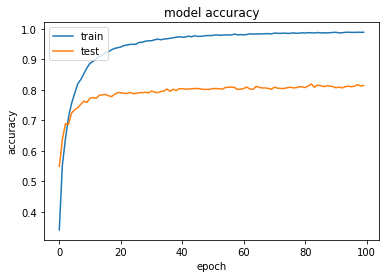

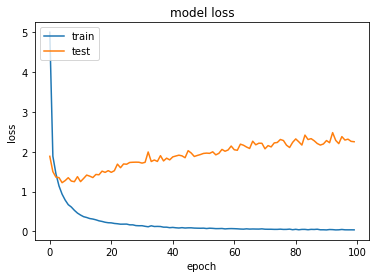

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

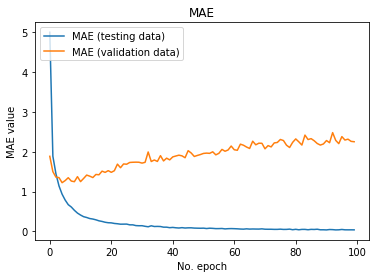

In [23]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

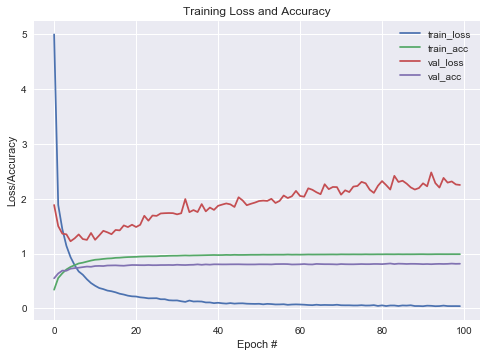

In [24]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()